Ablation 1: Feature Family

In [ ]:
from google.colab import files

In [3]:
minus_wind_channels = ['prev_fire',
 'temp',
 'rh',
 'ndvi',
 'slope',
 'aspect',
 'barrier',
 'erc',
 'pdsi',
 'pr',
 'bi',
 'chili',
 'fuel1',
 'fuel2',
 'fuel3',
 'impervious',
 'water']

In [4]:
# =========================================================
# 0) Setup (Colab installs) + Utilities
# =========================================================
!pip -q install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121
!pip -q install numpy pandas scikit-learn einops tqdm
!pip -q install kagglehub tensorflow

import os, math, random, glob
from dataclasses import dataclass
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.metrics import average_precision_score, precision_recall_curve

# Silence pipeline init logs unless overridden upstream
os.environ.setdefault("MNDWS_PIPELINE_SILENT", "1")
import mNDWS_DataPipeline as mndws_dp
WildfireDataset = mndws_dp.WildfireDataset
WildfirePaths = mndws_dp.WildfirePaths
CH_ORDER_BASE = mndws_dp.CH_ORDER_BASE
CH_ORDER_EXTRA = mndws_dp.CH_ORDER_EXTRA

def set_seed(seed=1337):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(1337)

if torch.cuda.is_available():
    device = torch.device("cuda")
    # Enable cuDNN autotuner only when CUDA is active
    try:
        torch.backends.cudnn.benchmark = True
    except Exception:
        pass
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

use_cuda = device.type == "cuda"
use_mps = device.type == "mps"
print("Device:", device)

No NPZ tiles found — converting from mNDWS TFRecords...
Using Colab cache for faster access to the 'modified-next-day-wildfire-spread' dataset.
Kaggle dataset path: /kaggle/input/modified-next-day-wildfire-spread


Converting TFRecords → NPZ (mNDWS): 100%|██████████| 54/54 [04:26<00:00,  4.94s/it]


Converted 20097 tiles → /scratch/root/wildfire_npz_tiles_mndws_v1
Skipped (no masks): 0


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Device: cuda


In [5]:
# --- Use shared mNDWS DataPipeline outputs for NPZ tiles and loaders ---
try:
    mndws_dp
except NameError:
    import os
    os.environ.setdefault("MNDWS_PIPELINE_SILENT", "1")
    import mNDWS_DataPipeline as mndws_dp
    WildfireDataset = mndws_dp.WildfireDataset
    WildfirePaths = mndws_dp.WildfirePaths
    CH_ORDER_BASE = mndws_dp.CH_ORDER_BASE
    CH_ORDER_EXTRA = mndws_dp.CH_ORDER_EXTRA

NPZ_ROOT = mndws_dp.NPZ_ROOT
print(f'Reusing NPZ tiles from pipeline at: {NPZ_ROOT}')

CHANNELS_FOR_MODEL = minus_wind_channels #list(mndws_dp.USE_CHANNELS)  # adjust here if you want fewer features
paths = mndws_dp.WildfirePaths(NPZ_ROOT)

train_ds = mndws_dp.WildfireDataset(paths, split='train', max_samples=1200, channels=CHANNELS_FOR_MODEL)
val_ds   = mndws_dp.WildfireDataset(paths, split='eval',  max_samples=300,  channels=CHANNELS_FOR_MODEL)
test_ds  = mndws_dp.WildfireDataset(paths, split='test',  max_samples=300,  channels=CHANNELS_FOR_MODEL)

train_loader = mndws_dp.make_loader(train_ds, batch_size=16, upweight_positive=True)
val_loader   = mndws_dp.make_loader(val_ds,   batch_size=16)
test_loader  = mndws_dp.make_loader(test_ds,  batch_size=16)

meanC, stdC = mndws_dp.compute_channel_stats(train_ds, n_max_samples=2000, batch_size=32)
meanC, stdC = meanC.to(device), stdC.to(device)

print(f'Channels configured ({len(CHANNELS_FOR_MODEL)}): {CHANNELS_FOR_MODEL}')

Reusing NPZ tiles from pipeline at: /scratch/root/wildfire_npz_tiles_mndws_v1
Channels configured (17): ['prev_fire', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water']


In [6]:
# =========================================================
# 4) Pixel Logistic Regression (1x1 conv) — mNDWS channel-aware, change number of epochs here
# =========================================================
import torch.nn as nn

class PixelLogReg(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.lin = nn.Conv2d(in_ch, 1, kernel_size=1, bias=True)
    def forward(self, x):
        return self.lin(x)  # logits (B,1,H,W)

def build_lr_input(X_raw0, mean=meanC, std=stdC):
    # Normalize using stats for the configured channels
    return (X_raw0 - mean.view(1, -1, 1, 1)) / std.view(1, -1, 1, 1)

@torch.no_grad()
def pos_weight_from_loader(loader, max_batches=100):
    total_pos = 0
    total = 0
    for i, b in enumerate(loader):
        y = b["y"]
        total_pos += y.sum().item()
        total     += y.numel()
        if i+1 >= max_batches: break
    pos = max(total_pos, 1.0)
    neg = max(total - total_pos, 1.0)
    return torch.tensor(neg / pos, dtype=torch.float32, device=device)

# Match model input to selected channels
n_ch = len(train_ds.channels)
assert meanC.numel() == n_ch and stdC.numel() == n_ch, "Stats must match channel count"

lr_model = PixelLogReg(in_ch=n_ch).to(device)
pw = pos_weight_from_loader(train_loader)
criterion = nn.BCEWithLogitsLoss(pos_weight=pw)
optimizer = torch.optim.AdamW(lr_model.parameters(), lr=1e-3, weight_decay=1e-4)

# change number of epochs here
EPOCHS_LR = 50
print("in_ch =", n_ch, "pos_weight =", float(pw))

in_ch = 17 pos_weight = 32.99687194824219


In [7]:
# =========================================================
# 5) Train / Eval loops, change number of epochs above
# =========================================================
import matplotlib.pyplot as plt
import time

def train_lr_epoch():
    lr_model.train()
    losses = []
    tiles_seen = 0
    for b in tqdm(train_loader, desc="train LR", leave=False):
        X_raw0, y = b["X_raw"].to(device, non_blocking=True), b["y"].to(device, non_blocking=True)
        X = build_lr_input(X_raw0)
        logits = lr_model(X)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        tiles_seen += X_raw0.size(0)
    return float(np.mean(losses)), tiles_seen

@torch.no_grad()
def eval_lr(loader):
    lr_model.eval()
    all_p, all_t = [], []
    for b in tqdm(loader, desc="eval LR", leave=False):
        X_raw0, y = b["X_raw"].to(device, non_blocking=True), b["y"].to(device, non_blocking=True)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p)
        all_t.append(t)
    p = np.concatenate(all_p)
    t = np.concatenate(all_t)
    if t.sum() == 0:
        return 0.0, 0.0, 0.5
    ap = average_precision_score(t, p)
    prec, rec, thr = precision_recall_curve(t, p)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    best_idx = f1.argmax()
    best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
    return float(ap), float(f1.max()), float(best_thr)

# Shared artifact path so we can skip retraining when cached weights exist
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "lr")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "pixel_logreg.pt")

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist = [], [], [], []
best_thr_val = 0.5
cached_artifact = False
artifact = {}

peak_gpu_gb = None
epoch_times = []
epoch_tiles = []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in lr_model.parameters() if p.requires_grad)),
}

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)

if os.path.exists(ART_PATH):
    print(f"Loading cached PixelLogReg artifact from {ART_PATH}")
    artifact = torch.load(ART_PATH, map_location=device)
    saved_channels = artifact.get("channels")
    current_channels = list(train_ds.channels)
    if saved_channels == current_channels:
        lr_model.load_state_dict(artifact["state_dict"])
        best_thr_val = float(artifact.get("best_thr", 0.5))
        train_loss_hist = list(artifact.get("train_loss_hist", []))
        val_ap_hist = list(artifact.get("val_ap_hist", []))
        val_f1_hist = list(artifact.get("val_f1_hist", []))
        val_thr_hist = list(artifact.get("val_thr_hist", []))
        compute_metrics.update(artifact.get("compute_metrics", {}))
        cached_artifact = True
    else:
        print("Cached artifact channel order differs from requested dataset; retraining.")
else:
    print("No cached PixelLogReg artifact found; training from scratch.")

if not cached_artifact:
    best_val_ap_lr = -1.0
    best_state = None

    for e in range(EPOCHS_LR):
        if use_cuda:
            torch.cuda.synchronize(device)
        elif use_mps:
            torch.mps.synchronize()
        epoch_start = time.perf_counter()
        tr_loss, tiles_seen = train_lr_epoch()
        if use_cuda:
            torch.cuda.synchronize(device)
        elif use_mps:
            torch.mps.synchronize()
        epoch_duration = time.perf_counter() - epoch_start
        epoch_times.append(epoch_duration)
        epoch_tiles.append(tiles_seen)
        ap, f1, thr = eval_lr(val_loader)
        train_loss_hist.append(tr_loss)
        val_ap_hist.append(ap)
        val_f1_hist.append(f1)
        val_thr_hist.append(thr)
        print(f"[LR] Epoch {e:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | thr≈{thr:.3f}")
        if ap > best_val_ap_lr:
            best_val_ap_lr = ap
            best_state = {k: v.cpu().clone() for k, v in lr_model.state_dict().items()}

    if best_state is not None:
        lr_model.load_state_dict(best_state)

    _, _, best_thr_val = eval_lr(val_loader)
    if val_thr_hist:
        val_thr_hist[-1] = best_thr_val
    else:
        val_thr_hist.append(best_thr_val)

    if epoch_times:
        avg_epoch = float(np.mean(epoch_times))
        std_epoch = float(np.std(epoch_times))
        total_time = float(np.sum(epoch_times))
        total_tiles = int(np.sum(epoch_tiles)) if epoch_tiles else 0
        throughput = float(total_tiles / total_time) if total_time > 0 else None
    else:
        avg_epoch = std_epoch = throughput = None
    if use_cuda:
        torch.cuda.synchronize(device)
        peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
    elif use_mps:
        torch.mps.synchronize()
    latency_s = None
else:
    if not val_thr_hist:
        val_ap, val_f1, best_thr_val = eval_lr(val_loader)
        val_ap_hist = [val_ap]
        val_f1_hist = [val_f1]
        val_thr_hist = [best_thr_val]
        print("Cached artifact missing history; recomputed validation metrics.")
    else:
        best_thr_val = float(artifact.get("best_thr", val_thr_hist[-1]))
    avg_epoch = compute_metrics.get("avg_epoch", None)
    std_epoch = compute_metrics.get("std_epoch", None)
    throughput = compute_metrics.get("throughput_tiles_per_s", None)
    peak_gpu_gb = compute_metrics.get("peak_gpu_gb", None)
    latency_s = compute_metrics.get("latency_s", None)

@torch.no_grad()
def test_at_thr(thr):
    lr_model.eval()
    all_p, all_t = [], []
    for b in tqdm(test_loader, desc="test LR", leave=False):
        X_raw0, y = b["X_raw"].to(device, non_blocking=True), b["y"].to(device, non_blocking=True)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p)
        all_t.append(t)
    p = np.concatenate(all_p)
    t = np.concatenate(all_t)
    ap = average_precision_score(t, p)
    yhat = (p >= thr).astype(np.float32)
    tp = (yhat * t).sum()
    fp = (yhat * (1 - t)).sum()
    fn = ((1 - yhat) * t).sum()
    prec = tp / (tp + fp + 1e-8)
    rec = tp / (tp + fn + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)
    print(f"[LR] TEST @thr={thr:.3f} | AP={ap:.4f} | P={prec:.3f} R={rec:.3f} F1={f1:.3f}")
    return ap, f1

test_ap_lr, test_f1_lr = test_at_thr(best_thr_val)

@torch.no_grad()
def measure_latency(ds, repeats=50):
    if len(ds) == 0:
        return None
    lr_model.eval()
    sample = ds[0]["X_raw"].unsqueeze(0).to(device)
    X = build_lr_input(sample)
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    start = time.perf_counter()
    for _ in range(repeats):
        torch.sigmoid(lr_model(X))
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    return (time.perf_counter() - start) / repeats

if latency_s is None:
    latency_s = measure_latency(test_ds, repeats=100)
if use_cuda and peak_gpu_gb is None:
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))

compute_metrics.update({
    "avg_epoch": avg_epoch,
    "std_epoch": std_epoch,
    "throughput_tiles_per_s": throughput,
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s,
})

No cached PixelLogReg artifact found; training from scratch.


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 00 | loss 1.4239 | VAL AP 0.0311 | VAL F1* 0.0623 | thr≈0.438


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 01 | loss 1.2987 | VAL AP 0.0491 | VAL F1* 0.0931 | thr≈0.580


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 02 | loss 1.2787 | VAL AP 0.0684 | VAL F1* 0.1277 | thr≈0.608


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 03 | loss 1.2588 | VAL AP 0.0854 | VAL F1* 0.1554 | thr≈0.624


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 04 | loss 1.2353 | VAL AP 0.1050 | VAL F1* 0.1814 | thr≈0.630


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 05 | loss 1.1712 | VAL AP 0.1229 | VAL F1* 0.2038 | thr≈0.643


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 06 | loss 1.1582 | VAL AP 0.1396 | VAL F1* 0.2233 | thr≈0.656


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 07 | loss 1.1886 | VAL AP 0.1560 | VAL F1* 0.2437 | thr≈0.663


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 08 | loss 1.1219 | VAL AP 0.1685 | VAL F1* 0.2587 | thr≈0.676


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 09 | loss 1.1123 | VAL AP 0.1802 | VAL F1* 0.2735 | thr≈0.684


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 10 | loss 1.1261 | VAL AP 0.1940 | VAL F1* 0.2903 | thr≈0.692


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 11 | loss 1.1386 | VAL AP 0.2004 | VAL F1* 0.2983 | thr≈0.703


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 12 | loss 1.1017 | VAL AP 0.2073 | VAL F1* 0.3069 | thr≈0.714


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 13 | loss 1.1230 | VAL AP 0.2170 | VAL F1* 0.3214 | thr≈0.710


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 14 | loss 1.0698 | VAL AP 0.2250 | VAL F1* 0.3346 | thr≈0.709


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 15 | loss 1.0708 | VAL AP 0.2280 | VAL F1* 0.3392 | thr≈0.719


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 16 | loss 1.0482 | VAL AP 0.2323 | VAL F1* 0.3473 | thr≈0.720


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 17 | loss 1.0760 | VAL AP 0.2360 | VAL F1* 0.3521 | thr≈0.726


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 18 | loss 1.0924 | VAL AP 0.2390 | VAL F1* 0.3611 | thr≈0.724


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 19 | loss 1.0710 | VAL AP 0.2427 | VAL F1* 0.3693 | thr≈0.724


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 20 | loss 1.0731 | VAL AP 0.2429 | VAL F1* 0.3700 | thr≈0.732


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 21 | loss 1.0443 | VAL AP 0.2476 | VAL F1* 0.3798 | thr≈0.730


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 22 | loss 1.0597 | VAL AP 0.2487 | VAL F1* 0.3814 | thr≈0.735


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 23 | loss 1.0568 | VAL AP 0.2505 | VAL F1* 0.3870 | thr≈0.737


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 24 | loss 1.0319 | VAL AP 0.2543 | VAL F1* 0.3968 | thr≈0.735


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 25 | loss 1.0023 | VAL AP 0.2544 | VAL F1* 0.3967 | thr≈0.738


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 26 | loss 1.0309 | VAL AP 0.2553 | VAL F1* 0.3982 | thr≈0.742


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 27 | loss 1.0419 | VAL AP 0.2554 | VAL F1* 0.3985 | thr≈0.754


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 28 | loss 1.0002 | VAL AP 0.2575 | VAL F1* 0.4038 | thr≈0.749


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 29 | loss 1.0306 | VAL AP 0.2585 | VAL F1* 0.4091 | thr≈0.741


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 30 | loss 0.9979 | VAL AP 0.2599 | VAL F1* 0.4156 | thr≈0.745


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 31 | loss 0.9794 | VAL AP 0.2602 | VAL F1* 0.4182 | thr≈0.739


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 32 | loss 0.9910 | VAL AP 0.2596 | VAL F1* 0.4212 | thr≈0.743


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 33 | loss 0.9769 | VAL AP 0.2614 | VAL F1* 0.4252 | thr≈0.740


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 34 | loss 1.0160 | VAL AP 0.2604 | VAL F1* 0.4230 | thr≈0.755


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 35 | loss 1.0192 | VAL AP 0.2595 | VAL F1* 0.4214 | thr≈0.762


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 36 | loss 0.9616 | VAL AP 0.2619 | VAL F1* 0.4270 | thr≈0.757


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 37 | loss 0.9929 | VAL AP 0.2623 | VAL F1* 0.4277 | thr≈0.760


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 38 | loss 1.0101 | VAL AP 0.2614 | VAL F1* 0.4252 | thr≈0.776


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 39 | loss 0.9904 | VAL AP 0.2611 | VAL F1* 0.4274 | thr≈0.757


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 40 | loss 0.9951 | VAL AP 0.2621 | VAL F1* 0.4283 | thr≈0.773


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 41 | loss 0.9894 | VAL AP 0.2626 | VAL F1* 0.4297 | thr≈0.771


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 42 | loss 0.9323 | VAL AP 0.2636 | VAL F1* 0.4312 | thr≈0.773


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 43 | loss 1.0032 | VAL AP 0.2630 | VAL F1* 0.4321 | thr≈0.760


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 44 | loss 0.9952 | VAL AP 0.2631 | VAL F1* 0.4318 | thr≈0.769


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 45 | loss 0.9657 | VAL AP 0.2643 | VAL F1* 0.4335 | thr≈0.769


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 46 | loss 1.0044 | VAL AP 0.2645 | VAL F1* 0.4339 | thr≈0.772


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 47 | loss 1.0087 | VAL AP 0.2645 | VAL F1* 0.4342 | thr≈0.785


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 48 | loss 0.9856 | VAL AP 0.2639 | VAL F1* 0.4352 | thr≈0.787


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 49 | loss 1.0089 | VAL AP 0.2633 | VAL F1* 0.4352 | thr≈0.791


eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


test LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] TEST @thr=0.785 | AP=0.2275 | P=0.388 R=0.453 F1=0.418


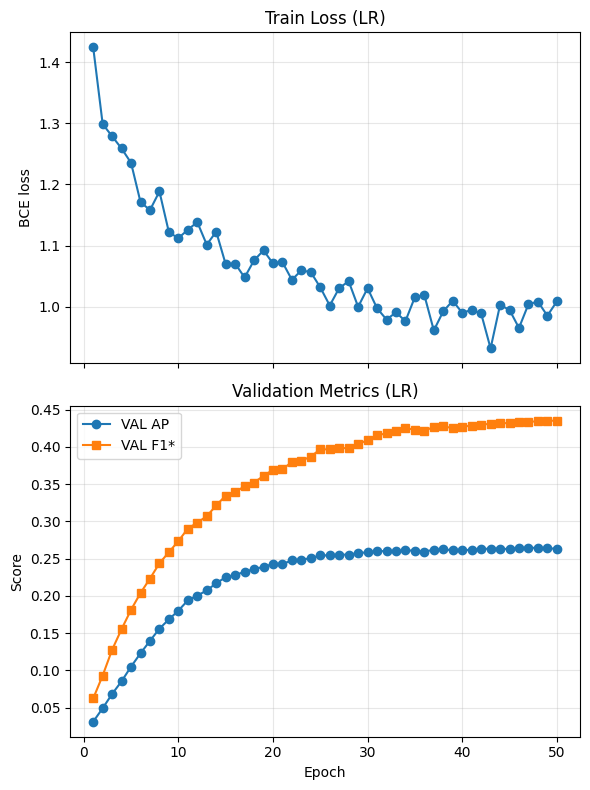

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
if not train_loss_hist:
    print("Training history empty — load skipped training or artifact lacks history. Run the training cell without a cached model to populate curves.")
else:
    epochs = np.arange(1, len(train_loss_hist) + 1)
    fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
    axes[0].plot(epochs, train_loss_hist, marker="o")
    axes[0].set_title("Train Loss (LR)")
    axes[0].set_ylabel("BCE loss")
    axes[0].grid(True, alpha=0.3)
    metric_epochs = np.arange(1, len(val_ap_hist) + 1)
    axes[1].plot(metric_epochs, val_ap_hist, marker="o", label="VAL AP")
    axes[1].plot(metric_epochs, val_f1_hist, marker="s", label="VAL F1*")
    axes[1].set_title("Validation Metrics (LR)")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Score")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("lr_metrics.png",dpi=300)
    plt.show()
    files.download("lr_metrics.png")

In [9]:
def _format_metric(val, unit=None, precision=3):
    if val is None:
        return "—"
    if isinstance(val, (int, np.integer)) and unit is None:
        return f"{int(val)}"
    if isinstance(val, (float, np.floating)):
        if np.isnan(val):
            return "—"
        if unit == "ms":
            return f"{val * 1e3:.3f} {unit}"
        if unit == "GB":
            return f"{val:.3f} {unit}"
        return f"{val:.3f}{'' if unit is None else ' ' + unit}"
    return str(val)

compute_metrics_display = {
    "Learnable parameters": _format_metric(compute_metrics.get("param_count")),
    "Avg. epoch wall time": _format_metric(compute_metrics.get("avg_epoch"), unit="s"),
    "Epoch time stdev": _format_metric(compute_metrics.get("std_epoch"), unit="s"),
    "Training throughput": _format_metric(compute_metrics.get("throughput_tiles_per_s"), unit="tiles/s"),
    "Peak GPU memory": _format_metric(compute_metrics.get("peak_gpu_gb"), unit="GB"),
    "Inference latency (1 tile)": _format_metric(compute_metrics.get("latency_s"), unit="ms"),
}

print("\n[LR] Computation metrics summary:")
for k, v in compute_metrics_display.items():
    print(f"  {k:28s} {v}")


[LR] Computation metrics summary:
  Learnable parameters         18
  Avg. epoch wall time         4.243 s
  Epoch time stdev             0.614 s
  Training throughput          282.831 tiles/s
  Peak GPU memory              0.018 GB
  Inference latency (1 tile)   0.115 ms


In [10]:
sample = train_ds[0]          # grab the first tile from the training split
img = sample["X_raw"]         # shape (channels, height, width)
print("Tensor shape:", img.shape)
print("Height x Width:", img.shape[1], "x", img.shape[2])

Tensor shape: torch.Size([17, 64, 64])
Height x Width: 64 x 64



[LR] Coefficients (sorted by |weight|):
  prev_fire        +2.4811
  bi               +0.3009
  pdsi             -0.2460
  barrier          -0.2407
  erc              +0.1760
  temp             +0.1500
  rh               -0.1230
  water            -0.1046
  fuel2            +0.0989
  slope            +0.0722
  ndvi             +0.0572
  fuel1            +0.0524
  ... (+5 more)
[LR] Bias: -0.6221


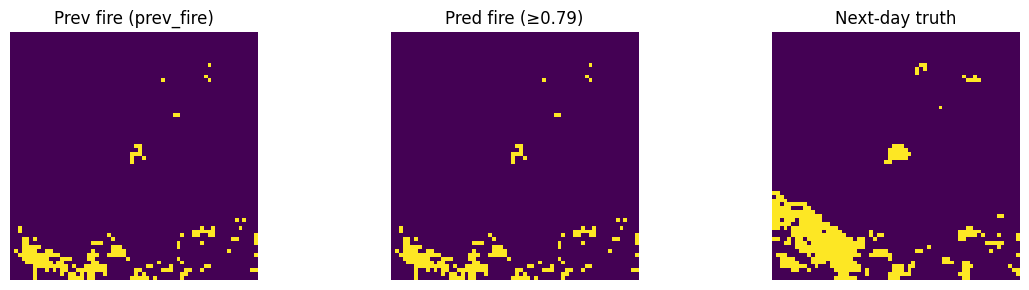

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
# =========================================================
# 6) Inspect coefficients + quick viz (channel-aware)
# =========================================================
import numpy as np
import torch
import matplotlib.pyplot as plt

with torch.no_grad():
    # Weight per input channel
    W = lr_model.lin.weight[0, :, 0, 0].detach().cpu().numpy()   # shape (C,)
    B = float(lr_model.lin.bias.item())

# Use the dataset's channel names (matches model input order)
channel_names = list(train_ds.channels)  # e.g., ["prev_fire","u","v",...]
assert len(W) == len(channel_names), "Weight length must match channel count"

# Sort by absolute weight; show top-k (or all)
top_k = min(12, len(W))
coef_sorted = sorted(zip(channel_names, W), key=lambda x: -abs(x[1]))
print("\n[LR] Coefficients (sorted by |weight|):")
for name, w in coef_sorted[:top_k]:
    print(f"  {name:16s} {w:+.4f}")
if top_k < len(W):
    print(f"  ... (+{len(W)-top_k} more)")
print(f"[LR] Bias: {B:+.4f}")

# Quick qualitative visualization (prev_fire, pred mask, next truth)
@torch.no_grad()
def show_one_lr(ds, i=0):
    names = ds.channels
    prev_idx = names.index("prev_fire") if "prev_fire" in names else 0

    b = ds[i]
    X_raw0 = b["X_raw"].unsqueeze(0).to(device)       # (1,C,H,W)
    y = b["y"][0].numpy()                              # (H,W)

    X = build_lr_input(X_raw0, mean=meanC, std=stdC)   # uses channel-aware stats
    prob = torch.sigmoid(lr_model(X))[0, 0].cpu().numpy()
    pred_fire = (prob >= float(best_thr_val)).astype(np.float32)

    prev_img = b["X_raw"][prev_idx].numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    axs[0].imshow(prev_img, vmin=0, vmax=1); axs[0].set_title(f"Prev fire ({names[prev_idx]})")
    axs[1].imshow(pred_fire, vmin=0, vmax=1); axs[1].set_title(f"Pred fire (≥{best_thr_val:.2f})")
    axs[2].imshow(y, vmin=0, vmax=1);        axs[2].set_title("Next-day truth")
    for a in axs: a.axis('off')
    plt.tight_layout();
    plt.savefig("lr_burnviz.png",dpi=300)
    plt.show()
    files.download("lr_burnviz.png")

# Example
show_one_lr(test_ds, i=0)

In [12]:
# =========================================================
# 7) Save artifacts (channel-aware, non-/content path)
# =========================================================
import os
import torch

ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "lr")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "pixel_logreg.pt")

artifact = {
    "state_dict": {k: v.cpu() for k, v in lr_model.state_dict().items()},
    "model": {"type": "PixelLogReg", "in_ch": len(train_ds.channels)},
    "channels": list(train_ds.channels),
    "mean": meanC.cpu(),
    "std": stdC.cpu(),
    "pos_weight": float(pw),
    "best_thr": float(best_thr_val),
    "train_loss_hist": list(train_loss_hist),
    "val_ap_hist": list(val_ap_hist),
    "val_f1_hist": list(val_f1_hist),
    "val_thr_hist": list(val_thr_hist),
    "compute_metrics": dict(compute_metrics),
}

torch.save(artifact, ART_PATH)
print(f"Saved model → {ART_PATH}")

Saved model → /root/wildfire_artifacts/lr/pixel_logreg.pt


In [13]:
test_ap_lr, test_f1_lr

(np.float64(0.22750334029751748), np.float32(0.41796893))

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] VAL: AP=0.2645 F1*=0.4342 thr≈0.785
VAL @thr: {'tp': 16834, 'fp': 23398, 'tn': 1168097, 'fn': 20471, 'precision': 0.4184231457545192, 'recall': 0.45125318321928665, 'f1': 0.43421849714147814}
TEST @thr: {'tp': 17599, 'fp': 27783, 'tn': 1162187, 'fn': 21231, 'precision': 0.38779692389044385, 'recall': 0.4532320370846116, 'f1': 0.4179689305737958}


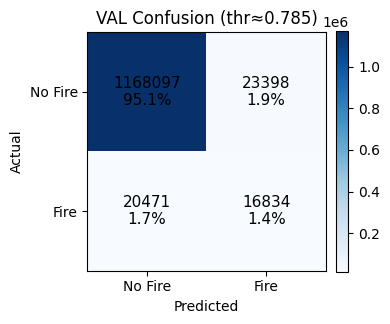

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

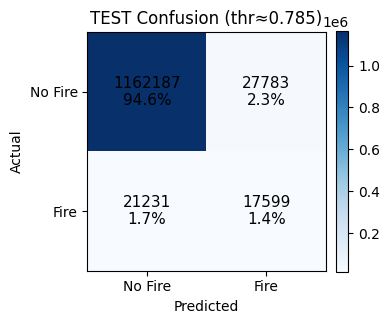

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_curve

# Reconfirm best threshold on VAL (uses your eval_lr)
val_ap, val_f1, best_thr_val = eval_lr(val_loader)
print(f"[LR] VAL: AP={val_ap:.4f} F1*={val_f1:.4f} thr≈{best_thr_val:.3f}")

@torch.no_grad()
def confusion_at_thr(loader, thr):
    lr_model.eval()
    tp = fp = tn = fn = 0
    for b in loader:
        X_raw0, y = b["X_raw"].to(device), b["y"].to(device)   # (B,1,H,W)
        X = build_lr_input(X_raw0)                              # normalize
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()  # probs
        t = y.flatten().cpu().numpy().astype(np.uint8)          # 0/1
        p = np.nan_to_num(p, nan=0.0)                           # safety
        yhat = (p >= thr).astype(np.uint8)
        tp += np.logical_and(yhat == 1, t == 1).sum()
        fp += np.logical_and(yhat == 1, t == 0).sum()
        tn += np.logical_and(yhat == 0, t == 0).sum()
        fn += np.logical_and(yhat == 0, t == 1).sum()
    tp, fp, tn, fn = map(int, (tp, fp, tn, fn))
    prec = tp / (tp + fp + 1e-8)
    rec  = tp / (tp + fn + 1e-8)
    f1   = 2 * prec * rec / (prec + rec + 1e-8)
    return dict(tp=tp, fp=fp, tn=tn, fn=fn,
                precision=float(prec), recall=float(rec), f1=float(f1))

def _conf_matrix_from_counts(stats):
    return np.array([[stats["tn"], stats["fp"]],
                     [stats["fn"], stats["tp"]]], dtype=np.int32)

def _plot_confusion(cm, title):
    total = cm.sum()
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["No Fire", "Fire"])
    ax.set_yticklabels(["No Fire", "Fire"])
    for (i, j), val in np.ndenumerate(cm):
        pct = (val / total * 100.0) if total else 0.0
        ax.text(j, i, f"{val}\n{pct:.1f}%", ha="center", va="center", color="black", fontsize=11)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout();
    plt.savefig("confusion.png",dpi=300)
    plt.show()
    files.download("confusion.png")

val_stats = confusion_at_thr(val_loader, best_thr_val)
test_stats = confusion_at_thr(test_loader, best_thr_val)

print("VAL @thr:", val_stats)
print("TEST @thr:", test_stats)

_plot_confusion(_conf_matrix_from_counts(val_stats), "VAL Confusion (thr≈{:.3f})".format(best_thr_val))
_plot_confusion(_conf_matrix_from_counts(test_stats), "TEST Confusion (thr≈{:.3f})".format(best_thr_val))



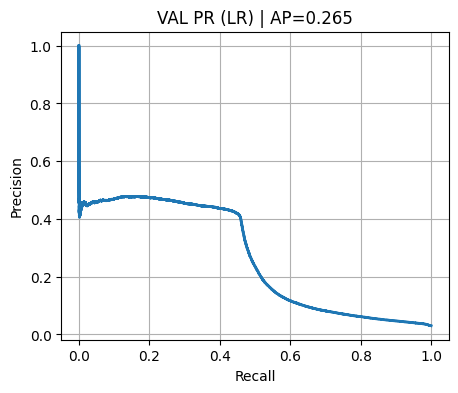

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

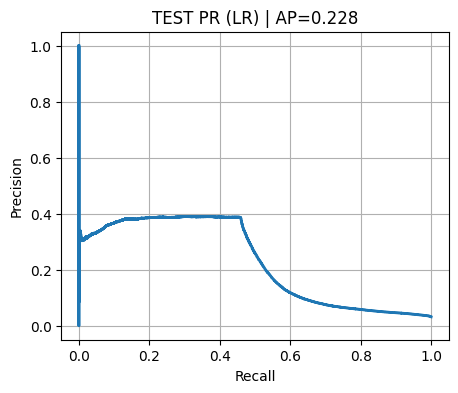

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [19]:
import matplotlib.pyplot as plt
from google.colab import files
@torch.no_grad()
def pr_curve(loader, title="PR Curve (LR)"):
    lr_model.eval()
    ps, ts = [], []
    for b in loader:
        X_raw0, y = b["X_raw"].to(device), b["y"].to(device)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        ps.append(p); ts.append(t)
    p = np.concatenate(ps); t = np.concatenate(ts)
    prec, rec, _ = precision_recall_curve(t, p)
    ap = average_precision_score(t, p)
    plt.figure(figsize=(5,4))
    plt.plot(rec, prec, lw=2)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title} | AP={ap:.3f}")
    plt.grid(True);
    plot_name = title.replace(" ", "_") + ".png"
    plt.savefig(plot_name,dpi=300)
    plt.show()
    files.download(plot_name)

pr_curve(val_loader, "VAL PR (LR)")
pr_curve(test_loader, "TEST PR (LR)")


In [16]:
# Single-feature ablation: evaluate LR using one channel at a time
single_feats = list(train_ds.channels)  # uses the configured channel order

@torch.no_grad()
def eval_single_feature(idx, loader=val_loader):
    C = len(single_feats)
    assert 0 <= idx < C, f"idx out of range (got {idx}, C={C})"

    # Save current weights/bias
    W_orig = lr_model.lin.weight.detach().clone()  # (1,C,1,1)
    b_orig = lr_model.lin.bias.detach().clone()

    # Zero all weights except the selected channel
    W_only = torch.zeros_like(W_orig)
    W_only[0, idx, 0, 0] = W_orig[0, idx, 0, 0]

    lr_model.lin.weight.data.copy_(W_only)
    lr_model.lin.bias.data.copy_(b_orig)  # keep bias unchanged

    # Evaluate on the given loader
    ap, f1, _ = eval_lr(loader)

    # Restore original weights/bias
    lr_model.lin.weight.data.copy_(W_orig)
    lr_model.lin.bias.data.copy_(b_orig)

    return ap, f1

abl = []
for i, nm in enumerate(single_feats):
    ap_i, f1_i = eval_single_feature(i, loader=val_loader)
    abl.append((nm, ap_i, f1_i))

abl = sorted(abl, key=lambda x: -x[2])  # sort by F1
print("\n[LR] Single-feature VAL ablations (sorted by F1):")
for nm, ap_i, f1_i in abl:
    print(f"  {nm:16s}  AP={ap_i:.3f}  F1*={f1_i:.3f}")

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]


[LR] Single-feature VAL ablations (sorted by F1):
  prev_fire         AP=0.210  F1*=0.439
  erc               AP=0.046  F1*=0.094
  pdsi              AP=0.043  F1*=0.089
  bi                AP=0.043  F1*=0.088
  rh                AP=0.040  F1*=0.073
  temp              AP=0.037  F1*=0.068
  slope             AP=0.035  F1*=0.065
  chili             AP=0.032  F1*=0.063
  barrier           AP=0.032  F1*=0.062
  fuel3             AP=0.030  F1*=0.062
  fuel2             AP=0.032  F1*=0.061
  fuel1             AP=0.029  F1*=0.061
  ndvi              AP=0.028  F1*=0.061
  water             AP=0.031  F1*=0.060
  impervious        AP=0.030  F1*=0.060
  aspect            AP=0.030  F1*=0.060
  pr                AP=0.030  F1*=0.059


--------- new

In [23]:
minus_fuel_channels = ['prev_fire',
 'u',
 'v',
 'temp',
 'rh',
 'ndvi',
 'slope',
 'aspect',
 'barrier',
 'erc',
 'pdsi',
 'pr',
 'bi',
 'chili',
 'impervious',
 'water',
 'wind_75',
 'gust_med']

In [24]:
# --- Use shared mNDWS DataPipeline outputs for NPZ tiles and loaders ---
try:
    mndws_dp
except NameError:
    import os
    os.environ.setdefault("MNDWS_PIPELINE_SILENT", "1")
    import mNDWS_DataPipeline as mndws_dp
    WildfireDataset = mndws_dp.WildfireDataset
    WildfirePaths = mndws_dp.WildfirePaths
    CH_ORDER_BASE = mndws_dp.CH_ORDER_BASE
    CH_ORDER_EXTRA = mndws_dp.CH_ORDER_EXTRA

NPZ_ROOT = mndws_dp.NPZ_ROOT
print(f'Reusing NPZ tiles from pipeline at: {NPZ_ROOT}')

CHANNELS_FOR_MODEL = minus_fuel_channels #list(mndws_dp.USE_CHANNELS)  # adjust here if you want fewer features
paths = mndws_dp.WildfirePaths(NPZ_ROOT)

train_ds = mndws_dp.WildfireDataset(paths, split='train', max_samples=1200, channels=CHANNELS_FOR_MODEL)
val_ds   = mndws_dp.WildfireDataset(paths, split='eval',  max_samples=300,  channels=CHANNELS_FOR_MODEL)
test_ds  = mndws_dp.WildfireDataset(paths, split='test',  max_samples=300,  channels=CHANNELS_FOR_MODEL)

train_loader = mndws_dp.make_loader(train_ds, batch_size=16, upweight_positive=True)
val_loader   = mndws_dp.make_loader(val_ds,   batch_size=16)
test_loader  = mndws_dp.make_loader(test_ds,  batch_size=16)

meanC, stdC = mndws_dp.compute_channel_stats(train_ds, n_max_samples=2000, batch_size=32)
meanC, stdC = meanC.to(device), stdC.to(device)

print(f'Channels configured ({len(CHANNELS_FOR_MODEL)}): {CHANNELS_FOR_MODEL}')

Reusing NPZ tiles from pipeline at: /scratch/root/wildfire_npz_tiles_mndws_v1


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Channels configured (18): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'impervious', 'water', 'wind_75', 'gust_med']


In [25]:
# =========================================================
# 4) Pixel Logistic Regression (1x1 conv) — mNDWS channel-aware, change number of epochs here
# =========================================================
import torch.nn as nn

class PixelLogReg(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.lin = nn.Conv2d(in_ch, 1, kernel_size=1, bias=True)
    def forward(self, x):
        return self.lin(x)  # logits (B,1,H,W)

def build_lr_input(X_raw0, mean=meanC, std=stdC):
    # Normalize using stats for the configured channels
    return (X_raw0 - mean.view(1, -1, 1, 1)) / std.view(1, -1, 1, 1)

@torch.no_grad()
def pos_weight_from_loader(loader, max_batches=100):
    total_pos = 0
    total = 0
    for i, b in enumerate(loader):
        y = b["y"]
        total_pos += y.sum().item()
        total     += y.numel()
        if i+1 >= max_batches: break
    pos = max(total_pos, 1.0)
    neg = max(total - total_pos, 1.0)
    return torch.tensor(neg / pos, dtype=torch.float32, device=device)

# Match model input to selected channels
n_ch = len(train_ds.channels)
assert meanC.numel() == n_ch and stdC.numel() == n_ch, "Stats must match channel count"

lr_model = PixelLogReg(in_ch=n_ch).to(device)
pw = pos_weight_from_loader(train_loader)
criterion = nn.BCEWithLogitsLoss(pos_weight=pw)
optimizer = torch.optim.AdamW(lr_model.parameters(), lr=1e-3, weight_decay=1e-4)

# change number of epochs here
EPOCHS_LR = 50
print("in_ch =", n_ch, "pos_weight =", float(pw))

in_ch = 18 pos_weight = 31.08501625061035


In [26]:
# =========================================================
# 5) Train / Eval loops, change number of epochs above
# =========================================================
import matplotlib.pyplot as plt
import time

def train_lr_epoch():
    lr_model.train()
    losses = []
    tiles_seen = 0
    for b in tqdm(train_loader, desc="train LR", leave=False):
        X_raw0, y = b["X_raw"].to(device, non_blocking=True), b["y"].to(device, non_blocking=True)
        X = build_lr_input(X_raw0)
        logits = lr_model(X)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        tiles_seen += X_raw0.size(0)
    return float(np.mean(losses)), tiles_seen

@torch.no_grad()
def eval_lr(loader):
    lr_model.eval()
    all_p, all_t = [], []
    for b in tqdm(loader, desc="eval LR", leave=False):
        X_raw0, y = b["X_raw"].to(device, non_blocking=True), b["y"].to(device, non_blocking=True)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p)
        all_t.append(t)
    p = np.concatenate(all_p)
    t = np.concatenate(all_t)
    if t.sum() == 0:
        return 0.0, 0.0, 0.5
    ap = average_precision_score(t, p)
    prec, rec, thr = precision_recall_curve(t, p)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    best_idx = f1.argmax()
    best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
    return float(ap), float(f1.max()), float(best_thr)

# Shared artifact path so we can skip retraining when cached weights exist
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "lr")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "pixel_logreg.pt")

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist = [], [], [], []
best_thr_val = 0.5
cached_artifact = False
artifact = {}

peak_gpu_gb = None
epoch_times = []
epoch_tiles = []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in lr_model.parameters() if p.requires_grad)),
}

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)

if os.path.exists(ART_PATH):
    print(f"Loading cached PixelLogReg artifact from {ART_PATH}")
    artifact = torch.load(ART_PATH, map_location=device)
    saved_channels = artifact.get("channels")
    current_channels = list(train_ds.channels)
    if saved_channels == current_channels:
        lr_model.load_state_dict(artifact["state_dict"])
        best_thr_val = float(artifact.get("best_thr", 0.5))
        train_loss_hist = list(artifact.get("train_loss_hist", []))
        val_ap_hist = list(artifact.get("val_ap_hist", []))
        val_f1_hist = list(artifact.get("val_f1_hist", []))
        val_thr_hist = list(artifact.get("val_thr_hist", []))
        compute_metrics.update(artifact.get("compute_metrics", {}))
        cached_artifact = True
    else:
        print("Cached artifact channel order differs from requested dataset; retraining.")
else:
    print("No cached PixelLogReg artifact found; training from scratch.")

if not cached_artifact:
    best_val_ap_lr = -1.0
    best_state = None

    for e in range(EPOCHS_LR):
        if use_cuda:
            torch.cuda.synchronize(device)
        elif use_mps:
            torch.mps.synchronize()
        epoch_start = time.perf_counter()
        tr_loss, tiles_seen = train_lr_epoch()
        if use_cuda:
            torch.cuda.synchronize(device)
        elif use_mps:
            torch.mps.synchronize()
        epoch_duration = time.perf_counter() - epoch_start
        epoch_times.append(epoch_duration)
        epoch_tiles.append(tiles_seen)
        ap, f1, thr = eval_lr(val_loader)
        train_loss_hist.append(tr_loss)
        val_ap_hist.append(ap)
        val_f1_hist.append(f1)
        val_thr_hist.append(thr)
        print(f"[LR] Epoch {e:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | thr≈{thr:.3f}")
        if ap > best_val_ap_lr:
            best_val_ap_lr = ap
            best_state = {k: v.cpu().clone() for k, v in lr_model.state_dict().items()}

    if best_state is not None:
        lr_model.load_state_dict(best_state)

    _, _, best_thr_val = eval_lr(val_loader)
    if val_thr_hist:
        val_thr_hist[-1] = best_thr_val
    else:
        val_thr_hist.append(best_thr_val)

    if epoch_times:
        avg_epoch = float(np.mean(epoch_times))
        std_epoch = float(np.std(epoch_times))
        total_time = float(np.sum(epoch_times))
        total_tiles = int(np.sum(epoch_tiles)) if epoch_tiles else 0
        throughput = float(total_tiles / total_time) if total_time > 0 else None
    else:
        avg_epoch = std_epoch = throughput = None
    if use_cuda:
        torch.cuda.synchronize(device)
        peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
    elif use_mps:
        torch.mps.synchronize()
    latency_s = None
else:
    if not val_thr_hist:
        val_ap, val_f1, best_thr_val = eval_lr(val_loader)
        val_ap_hist = [val_ap]
        val_f1_hist = [val_f1]
        val_thr_hist = [best_thr_val]
        print("Cached artifact missing history; recomputed validation metrics.")
    else:
        best_thr_val = float(artifact.get("best_thr", val_thr_hist[-1]))
    avg_epoch = compute_metrics.get("avg_epoch", None)
    std_epoch = compute_metrics.get("std_epoch", None)
    throughput = compute_metrics.get("throughput_tiles_per_s", None)
    peak_gpu_gb = compute_metrics.get("peak_gpu_gb", None)
    latency_s = compute_metrics.get("latency_s", None)

@torch.no_grad()
def test_at_thr(thr):
    lr_model.eval()
    all_p, all_t = [], []
    for b in tqdm(test_loader, desc="test LR", leave=False):
        X_raw0, y = b["X_raw"].to(device, non_blocking=True), b["y"].to(device, non_blocking=True)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p)
        all_t.append(t)
    p = np.concatenate(all_p)
    t = np.concatenate(all_t)
    ap = average_precision_score(t, p)
    yhat = (p >= thr).astype(np.float32)
    tp = (yhat * t).sum()
    fp = (yhat * (1 - t)).sum()
    fn = ((1 - yhat) * t).sum()
    prec = tp / (tp + fp + 1e-8)
    rec = tp / (tp + fn + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)
    print(f"[LR] TEST @thr={thr:.3f} | AP={ap:.4f} | P={prec:.3f} R={rec:.3f} F1={f1:.3f}")
    return ap, f1

test_ap_lr, test_f1_lr = test_at_thr(best_thr_val)

@torch.no_grad()
def measure_latency(ds, repeats=50):
    if len(ds) == 0:
        return None
    lr_model.eval()
    sample = ds[0]["X_raw"].unsqueeze(0).to(device)
    X = build_lr_input(sample)
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    start = time.perf_counter()
    for _ in range(repeats):
        torch.sigmoid(lr_model(X))
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    return (time.perf_counter() - start) / repeats

if latency_s is None:
    latency_s = measure_latency(test_ds, repeats=100)
if use_cuda and peak_gpu_gb is None:
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))

compute_metrics.update({
    "avg_epoch": avg_epoch,
    "std_epoch": std_epoch,
    "throughput_tiles_per_s": throughput,
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s,
})

Loading cached PixelLogReg artifact from /root/wildfire_artifacts/lr/pixel_logreg.pt
Cached artifact channel order differs from requested dataset; retraining.


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 00 | loss 1.2711 | VAL AP 0.0461 | VAL F1* 0.0877 | thr≈0.604


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 01 | loss 1.2308 | VAL AP 0.0566 | VAL F1* 0.1095 | thr≈0.610


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 02 | loss 1.2029 | VAL AP 0.0648 | VAL F1* 0.1235 | thr≈0.614


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 03 | loss 1.1440 | VAL AP 0.0713 | VAL F1* 0.1352 | thr≈0.617


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 04 | loss 1.1695 | VAL AP 0.0783 | VAL F1* 0.1485 | thr≈0.630


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 05 | loss 1.1479 | VAL AP 0.0861 | VAL F1* 0.1632 | thr≈0.642


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 06 | loss 1.1388 | VAL AP 0.0943 | VAL F1* 0.1795 | thr≈0.651


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 07 | loss 1.0997 | VAL AP 0.1033 | VAL F1* 0.1984 | thr≈0.653


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 08 | loss 1.1010 | VAL AP 0.1127 | VAL F1* 0.2150 | thr≈0.659


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 09 | loss 1.0998 | VAL AP 0.1229 | VAL F1* 0.2304 | thr≈0.663


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 10 | loss 1.0504 | VAL AP 0.1331 | VAL F1* 0.2439 | thr≈0.670


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 11 | loss 1.0650 | VAL AP 0.1423 | VAL F1* 0.2554 | thr≈0.678


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 12 | loss 1.0522 | VAL AP 0.1551 | VAL F1* 0.2699 | thr≈0.676


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 13 | loss 1.0740 | VAL AP 0.1651 | VAL F1* 0.2776 | thr≈0.694


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 14 | loss 1.0484 | VAL AP 0.1740 | VAL F1* 0.2915 | thr≈0.689


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 15 | loss 1.0649 | VAL AP 0.1774 | VAL F1* 0.2988 | thr≈0.702


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 16 | loss 1.0362 | VAL AP 0.1911 | VAL F1* 0.3145 | thr≈0.704


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 17 | loss 1.0663 | VAL AP 0.1971 | VAL F1* 0.3224 | thr≈0.707


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 18 | loss 1.0396 | VAL AP 0.2036 | VAL F1* 0.3317 | thr≈0.696


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 19 | loss 1.0146 | VAL AP 0.2107 | VAL F1* 0.3417 | thr≈0.699


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 20 | loss 1.0296 | VAL AP 0.2188 | VAL F1* 0.3527 | thr≈0.706


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 21 | loss 1.0129 | VAL AP 0.2213 | VAL F1* 0.3569 | thr≈0.710


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 22 | loss 0.9973 | VAL AP 0.2272 | VAL F1* 0.3650 | thr≈0.717


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 23 | loss 0.9974 | VAL AP 0.2298 | VAL F1* 0.3702 | thr≈0.720


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 24 | loss 0.9808 | VAL AP 0.2344 | VAL F1* 0.3796 | thr≈0.718


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 25 | loss 0.9737 | VAL AP 0.2351 | VAL F1* 0.3802 | thr≈0.719


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 26 | loss 0.9700 | VAL AP 0.2346 | VAL F1* 0.3793 | thr≈0.729


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 27 | loss 1.0038 | VAL AP 0.2379 | VAL F1* 0.3854 | thr≈0.722


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 28 | loss 0.9778 | VAL AP 0.2361 | VAL F1* 0.3837 | thr≈0.728


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 29 | loss 0.9983 | VAL AP 0.2405 | VAL F1* 0.3904 | thr≈0.724


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 30 | loss 0.9671 | VAL AP 0.2431 | VAL F1* 0.3962 | thr≈0.718


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 31 | loss 0.9949 | VAL AP 0.2436 | VAL F1* 0.3991 | thr≈0.730


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 32 | loss 0.9702 | VAL AP 0.2435 | VAL F1* 0.3988 | thr≈0.734


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 33 | loss 0.9327 | VAL AP 0.2449 | VAL F1* 0.4033 | thr≈0.725


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 34 | loss 0.9648 | VAL AP 0.2450 | VAL F1* 0.4054 | thr≈0.730


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 35 | loss 0.9772 | VAL AP 0.2461 | VAL F1* 0.4058 | thr≈0.749


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 36 | loss 1.0088 | VAL AP 0.2448 | VAL F1* 0.4070 | thr≈0.763


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 37 | loss 0.9401 | VAL AP 0.2447 | VAL F1* 0.4078 | thr≈0.764


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 38 | loss 0.9635 | VAL AP 0.2449 | VAL F1* 0.4121 | thr≈0.766


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 39 | loss 0.9661 | VAL AP 0.2464 | VAL F1* 0.4141 | thr≈0.767


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 40 | loss 0.9506 | VAL AP 0.2457 | VAL F1* 0.4145 | thr≈0.773


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 41 | loss 0.9898 | VAL AP 0.2454 | VAL F1* 0.4144 | thr≈0.777


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 42 | loss 0.9105 | VAL AP 0.2468 | VAL F1* 0.4188 | thr≈0.776


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 43 | loss 0.9436 | VAL AP 0.2473 | VAL F1* 0.4192 | thr≈0.782


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 44 | loss 0.9574 | VAL AP 0.2487 | VAL F1* 0.4220 | thr≈0.787


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 45 | loss 0.9318 | VAL AP 0.2493 | VAL F1* 0.4235 | thr≈0.788


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 46 | loss 0.9525 | VAL AP 0.2502 | VAL F1* 0.4244 | thr≈0.793


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 47 | loss 0.9724 | VAL AP 0.2507 | VAL F1* 0.4249 | thr≈0.791


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 48 | loss 0.9412 | VAL AP 0.2494 | VAL F1* 0.4235 | thr≈0.808


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 49 | loss 0.9521 | VAL AP 0.2500 | VAL F1* 0.4263 | thr≈0.773


eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


test LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] TEST @thr=0.791 | AP=0.2313 | P=0.382 R=0.437 F1=0.408


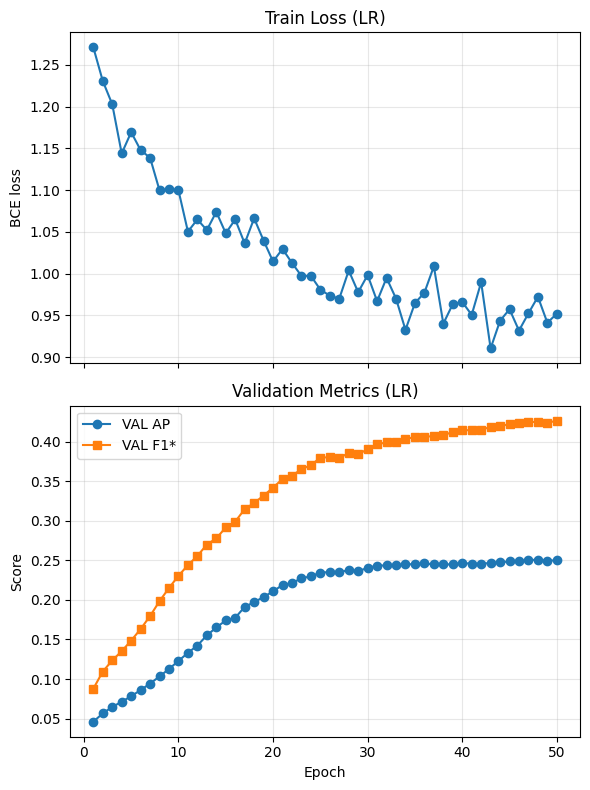

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
if not train_loss_hist:
    print("Training history empty — load skipped training or artifact lacks history. Run the training cell without a cached model to populate curves.")
else:
    epochs = np.arange(1, len(train_loss_hist) + 1)
    fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
    axes[0].plot(epochs, train_loss_hist, marker="o")
    axes[0].set_title("Train Loss (LR)")
    axes[0].set_ylabel("BCE loss")
    axes[0].grid(True, alpha=0.3)
    metric_epochs = np.arange(1, len(val_ap_hist) + 1)
    axes[1].plot(metric_epochs, val_ap_hist, marker="o", label="VAL AP")
    axes[1].plot(metric_epochs, val_f1_hist, marker="s", label="VAL F1*")
    axes[1].set_title("Validation Metrics (LR)")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Score")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("lr_metrics.png",dpi=300)
    plt.show()
    files.download("lr_metrics.png")

In [28]:
def _format_metric(val, unit=None, precision=3):
    if val is None:
        return "—"
    if isinstance(val, (int, np.integer)) and unit is None:
        return f"{int(val)}"
    if isinstance(val, (float, np.floating)):
        if np.isnan(val):
            return "—"
        if unit == "ms":
            return f"{val * 1e3:.3f} {unit}"
        if unit == "GB":
            return f"{val:.3f} {unit}"
        return f"{val:.3f}{'' if unit is None else ' ' + unit}"
    return str(val)

compute_metrics_display = {
    "Learnable parameters": _format_metric(compute_metrics.get("param_count")),
    "Avg. epoch wall time": _format_metric(compute_metrics.get("avg_epoch"), unit="s"),
    "Epoch time stdev": _format_metric(compute_metrics.get("std_epoch"), unit="s"),
    "Training throughput": _format_metric(compute_metrics.get("throughput_tiles_per_s"), unit="tiles/s"),
    "Peak GPU memory": _format_metric(compute_metrics.get("peak_gpu_gb"), unit="GB"),
    "Inference latency (1 tile)": _format_metric(compute_metrics.get("latency_s"), unit="ms"),
}

print("\n[LR] Computation metrics summary:")
for k, v in compute_metrics_display.items():
    print(f"  {k:28s} {v}")


[LR] Computation metrics summary:
  Learnable parameters         19
  Avg. epoch wall time         4.507 s
  Epoch time stdev             0.562 s
  Training throughput          266.278 tiles/s
  Peak GPU memory              0.032 GB
  Inference latency (1 tile)   0.141 ms


In [29]:
sample = train_ds[0]          # grab the first tile from the training split
img = sample["X_raw"]         # shape (channels, height, width)
print("Tensor shape:", img.shape)
print("Height x Width:", img.shape[1], "x", img.shape[2])

Tensor shape: torch.Size([18, 64, 64])
Height x Width: 64 x 64



[LR] Coefficients (sorted by |weight|):
  prev_fire        +2.4237
  gust_med         +0.3587
  pdsi             -0.2643
  wind_75          -0.2471
  erc              +0.2284
  barrier          -0.2173
  bi               +0.2130
  temp             +0.2046
  water            -0.1111
  rh               -0.0992
  slope            +0.0918
  v                -0.0761
  ... (+6 more)
[LR] Bias: -0.6931


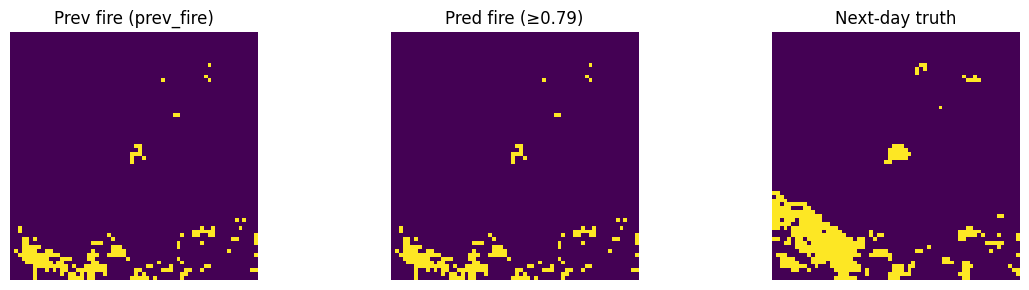

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
# =========================================================
# 6) Inspect coefficients + quick viz (channel-aware)
# =========================================================
import numpy as np
import torch
import matplotlib.pyplot as plt

with torch.no_grad():
    # Weight per input channel
    W = lr_model.lin.weight[0, :, 0, 0].detach().cpu().numpy()   # shape (C,)
    B = float(lr_model.lin.bias.item())

# Use the dataset's channel names (matches model input order)
channel_names = list(train_ds.channels)  # e.g., ["prev_fire","u","v",...]
assert len(W) == len(channel_names), "Weight length must match channel count"

# Sort by absolute weight; show top-k (or all)
top_k = min(12, len(W))
coef_sorted = sorted(zip(channel_names, W), key=lambda x: -abs(x[1]))
print("\n[LR] Coefficients (sorted by |weight|):")
for name, w in coef_sorted[:top_k]:
    print(f"  {name:16s} {w:+.4f}")
if top_k < len(W):
    print(f"  ... (+{len(W)-top_k} more)")
print(f"[LR] Bias: {B:+.4f}")

# Quick qualitative visualization (prev_fire, pred mask, next truth)
@torch.no_grad()
def show_one_lr(ds, i=0):
    names = ds.channels
    prev_idx = names.index("prev_fire") if "prev_fire" in names else 0

    b = ds[i]
    X_raw0 = b["X_raw"].unsqueeze(0).to(device)       # (1,C,H,W)
    y = b["y"][0].numpy()                              # (H,W)

    X = build_lr_input(X_raw0, mean=meanC, std=stdC)   # uses channel-aware stats
    prob = torch.sigmoid(lr_model(X))[0, 0].cpu().numpy()
    pred_fire = (prob >= float(best_thr_val)).astype(np.float32)

    prev_img = b["X_raw"][prev_idx].numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    axs[0].imshow(prev_img, vmin=0, vmax=1); axs[0].set_title(f"Prev fire ({names[prev_idx]})")
    axs[1].imshow(pred_fire, vmin=0, vmax=1); axs[1].set_title(f"Pred fire (≥{best_thr_val:.2f})")
    axs[2].imshow(y, vmin=0, vmax=1);        axs[2].set_title("Next-day truth")
    for a in axs: a.axis('off')
    plt.tight_layout();
    plt.savefig("lr_burnviz.png",dpi=300)
    plt.show()
    files.download("lr_burnviz.png")

# Example
show_one_lr(test_ds, i=0)

In [31]:
# =========================================================
# 7) Save artifacts (channel-aware, non-/content path)
# =========================================================
import os
import torch

ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "lr")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "pixel_logreg.pt")

artifact = {
    "state_dict": {k: v.cpu() for k, v in lr_model.state_dict().items()},
    "model": {"type": "PixelLogReg", "in_ch": len(train_ds.channels)},
    "channels": list(train_ds.channels),
    "mean": meanC.cpu(),
    "std": stdC.cpu(),
    "pos_weight": float(pw),
    "best_thr": float(best_thr_val),
    "train_loss_hist": list(train_loss_hist),
    "val_ap_hist": list(val_ap_hist),
    "val_f1_hist": list(val_f1_hist),
    "val_thr_hist": list(val_thr_hist),
    "compute_metrics": dict(compute_metrics),
}

torch.save(artifact, ART_PATH)
print(f"Saved model → {ART_PATH}")

Saved model → /root/wildfire_artifacts/lr/pixel_logreg.pt


In [32]:
test_ap_lr, test_f1_lr

(np.float64(0.23127412709224532), np.float32(0.4077206))

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] VAL: AP=0.2507 F1*=0.4249 thr≈0.791
VAL @thr: {'tp': 16201, 'fp': 22751, 'tn': 1168744, 'fn': 21104, 'precision': 0.41592216060782095, 'recall': 0.4342849483982216, 'f1': 0.4249052496017987}
TEST @thr: {'tp': 16973, 'fp': 27455, 'tn': 1162515, 'fn': 21857, 'precision': 0.38203385252534844, 'recall': 0.43711048158628973, 'f1': 0.40772057442628706}


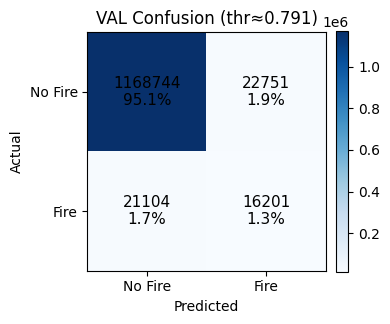

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

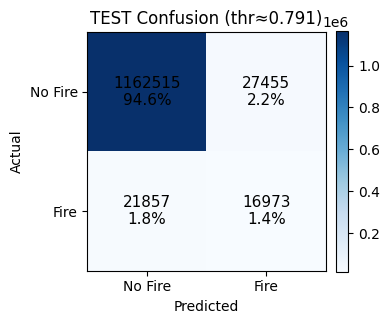

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_curve

# Reconfirm best threshold on VAL (uses your eval_lr)
val_ap, val_f1, best_thr_val = eval_lr(val_loader)
print(f"[LR] VAL: AP={val_ap:.4f} F1*={val_f1:.4f} thr≈{best_thr_val:.3f}")

@torch.no_grad()
def confusion_at_thr(loader, thr):
    lr_model.eval()
    tp = fp = tn = fn = 0
    for b in loader:
        X_raw0, y = b["X_raw"].to(device), b["y"].to(device)   # (B,1,H,W)
        X = build_lr_input(X_raw0)                              # normalize
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()  # probs
        t = y.flatten().cpu().numpy().astype(np.uint8)          # 0/1
        p = np.nan_to_num(p, nan=0.0)                           # safety
        yhat = (p >= thr).astype(np.uint8)
        tp += np.logical_and(yhat == 1, t == 1).sum()
        fp += np.logical_and(yhat == 1, t == 0).sum()
        tn += np.logical_and(yhat == 0, t == 0).sum()
        fn += np.logical_and(yhat == 0, t == 1).sum()
    tp, fp, tn, fn = map(int, (tp, fp, tn, fn))
    prec = tp / (tp + fp + 1e-8)
    rec  = tp / (tp + fn + 1e-8)
    f1   = 2 * prec * rec / (prec + rec + 1e-8)
    return dict(tp=tp, fp=fp, tn=tn, fn=fn,
                precision=float(prec), recall=float(rec), f1=float(f1))

def _conf_matrix_from_counts(stats):
    return np.array([[stats["tn"], stats["fp"]],
                     [stats["fn"], stats["tp"]]], dtype=np.int32)

def _plot_confusion(cm, title):
    total = cm.sum()
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["No Fire", "Fire"])
    ax.set_yticklabels(["No Fire", "Fire"])
    for (i, j), val in np.ndenumerate(cm):
        pct = (val / total * 100.0) if total else 0.0
        ax.text(j, i, f"{val}\n{pct:.1f}%", ha="center", va="center", color="black", fontsize=11)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout();
    plt.savefig("confusion.png",dpi=300)
    plt.show()
    files.download("confusion.png")

val_stats = confusion_at_thr(val_loader, best_thr_val)
test_stats = confusion_at_thr(test_loader, best_thr_val)

print("VAL @thr:", val_stats)
print("TEST @thr:", test_stats)

_plot_confusion(_conf_matrix_from_counts(val_stats), "VAL Confusion (thr≈{:.3f})".format(best_thr_val))
_plot_confusion(_conf_matrix_from_counts(test_stats), "TEST Confusion (thr≈{:.3f})".format(best_thr_val))



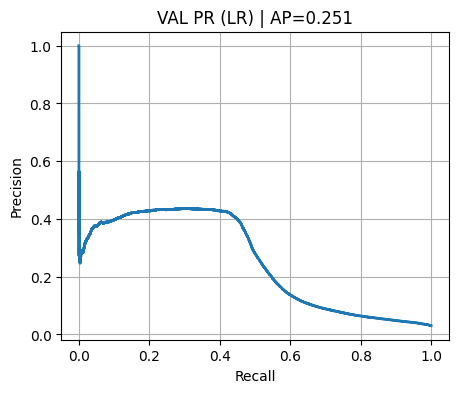

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

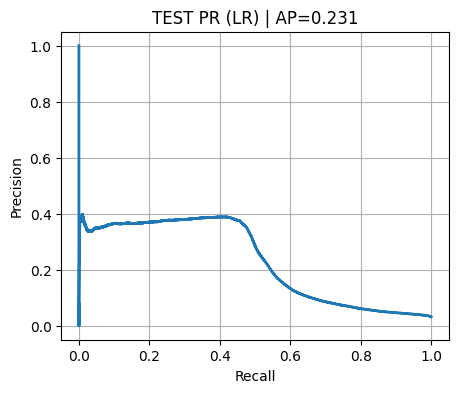

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [34]:
import matplotlib.pyplot as plt
from google.colab import files
@torch.no_grad()
def pr_curve(loader, title="PR Curve (LR)"):
    lr_model.eval()
    ps, ts = [], []
    for b in loader:
        X_raw0, y = b["X_raw"].to(device), b["y"].to(device)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        ps.append(p); ts.append(t)
    p = np.concatenate(ps); t = np.concatenate(ts)
    prec, rec, _ = precision_recall_curve(t, p)
    ap = average_precision_score(t, p)
    plt.figure(figsize=(5,4))
    plt.plot(rec, prec, lw=2)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title} | AP={ap:.3f}")
    plt.grid(True);
    plot_name = title.replace(" ", "_") + ".png"
    plt.savefig(plot_name,dpi=300)
    plt.show()
    files.download(plot_name)

pr_curve(val_loader, "VAL PR (LR)")
pr_curve(test_loader, "TEST PR (LR)")


In [35]:
# Single-feature ablation: evaluate LR using one channel at a time
single_feats = list(train_ds.channels)  # uses the configured channel order

@torch.no_grad()
def eval_single_feature(idx, loader=val_loader):
    C = len(single_feats)
    assert 0 <= idx < C, f"idx out of range (got {idx}, C={C})"

    # Save current weights/bias
    W_orig = lr_model.lin.weight.detach().clone()  # (1,C,1,1)
    b_orig = lr_model.lin.bias.detach().clone()

    # Zero all weights except the selected channel
    W_only = torch.zeros_like(W_orig)
    W_only[0, idx, 0, 0] = W_orig[0, idx, 0, 0]

    lr_model.lin.weight.data.copy_(W_only)
    lr_model.lin.bias.data.copy_(b_orig)  # keep bias unchanged

    # Evaluate on the given loader
    ap, f1, _ = eval_lr(loader)

    # Restore original weights/bias
    lr_model.lin.weight.data.copy_(W_orig)
    lr_model.lin.bias.data.copy_(b_orig)

    return ap, f1

abl = []
for i, nm in enumerate(single_feats):
    ap_i, f1_i = eval_single_feature(i, loader=val_loader)
    abl.append((nm, ap_i, f1_i))

abl = sorted(abl, key=lambda x: -x[2])  # sort by F1
print("\n[LR] Single-feature VAL ablations (sorted by F1):")
for nm, ap_i, f1_i in abl:
    print(f"  {nm:16s}  AP={ap_i:.3f}  F1*={f1_i:.3f}")

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]


[LR] Single-feature VAL ablations (sorted by F1):
  prev_fire         AP=0.210  F1*=0.439
  erc               AP=0.046  F1*=0.094
  pdsi              AP=0.043  F1*=0.089
  bi                AP=0.043  F1*=0.088
  rh                AP=0.040  F1*=0.073
  temp              AP=0.037  F1*=0.068
  v                 AP=0.033  F1*=0.065
  slope             AP=0.035  F1*=0.065
  gust_med          AP=0.034  F1*=0.065
  pr                AP=0.032  F1*=0.063
  barrier           AP=0.032  F1*=0.062
  ndvi              AP=0.028  F1*=0.061
  water             AP=0.031  F1*=0.060
  u                 AP=0.030  F1*=0.060
  impervious        AP=0.030  F1*=0.060
  wind_75           AP=0.027  F1*=0.060
  aspect            AP=0.030  F1*=0.060
  chili             AP=0.029  F1*=0.059


In [36]:
minus_vegd_channels = ['prev_fire',
 'u',
 'v',
 'temp',
 'rh',
 'slope',
 'aspect',
 'barrier',
 'erc',
 'pr',
 'bi',
 'chili',
 'fuel1',
 'fuel2',
 'fuel3',
 'impervious',
 'water',
 'wind_75',
 'gust_med']

In [37]:
# --- Use shared mNDWS DataPipeline outputs for NPZ tiles and loaders ---
try:
    mndws_dp
except NameError:
    import os
    os.environ.setdefault("MNDWS_PIPELINE_SILENT", "1")
    import mNDWS_DataPipeline as mndws_dp
    WildfireDataset = mndws_dp.WildfireDataset
    WildfirePaths = mndws_dp.WildfirePaths
    CH_ORDER_BASE = mndws_dp.CH_ORDER_BASE
    CH_ORDER_EXTRA = mndws_dp.CH_ORDER_EXTRA

NPZ_ROOT = mndws_dp.NPZ_ROOT
print(f'Reusing NPZ tiles from pipeline at: {NPZ_ROOT}')

CHANNELS_FOR_MODEL = minus_vegd_channels #list(mndws_dp.USE_CHANNELS)  # adjust here if you want fewer features
paths = mndws_dp.WildfirePaths(NPZ_ROOT)

train_ds = mndws_dp.WildfireDataset(paths, split='train', max_samples=1200, channels=CHANNELS_FOR_MODEL)
val_ds   = mndws_dp.WildfireDataset(paths, split='eval',  max_samples=300,  channels=CHANNELS_FOR_MODEL)
test_ds  = mndws_dp.WildfireDataset(paths, split='test',  max_samples=300,  channels=CHANNELS_FOR_MODEL)

train_loader = mndws_dp.make_loader(train_ds, batch_size=16, upweight_positive=True)
val_loader   = mndws_dp.make_loader(val_ds,   batch_size=16)
test_loader  = mndws_dp.make_loader(test_ds,  batch_size=16)

meanC, stdC = mndws_dp.compute_channel_stats(train_ds, n_max_samples=2000, batch_size=32)
meanC, stdC = meanC.to(device), stdC.to(device)

print(f'Channels configured ({len(CHANNELS_FOR_MODEL)}): {CHANNELS_FOR_MODEL}')

Reusing NPZ tiles from pipeline at: /scratch/root/wildfire_npz_tiles_mndws_v1


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Channels configured (19): ['prev_fire', 'u', 'v', 'temp', 'rh', 'slope', 'aspect', 'barrier', 'erc', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']


In [38]:
# =========================================================
# 4) Pixel Logistic Regression (1x1 conv) — mNDWS channel-aware, change number of epochs here
# =========================================================
import torch.nn as nn

class PixelLogReg(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.lin = nn.Conv2d(in_ch, 1, kernel_size=1, bias=True)
    def forward(self, x):
        return self.lin(x)  # logits (B,1,H,W)

def build_lr_input(X_raw0, mean=meanC, std=stdC):
    # Normalize using stats for the configured channels
    return (X_raw0 - mean.view(1, -1, 1, 1)) / std.view(1, -1, 1, 1)

@torch.no_grad()
def pos_weight_from_loader(loader, max_batches=100):
    total_pos = 0
    total = 0
    for i, b in enumerate(loader):
        y = b["y"]
        total_pos += y.sum().item()
        total     += y.numel()
        if i+1 >= max_batches: break
    pos = max(total_pos, 1.0)
    neg = max(total - total_pos, 1.0)
    return torch.tensor(neg / pos, dtype=torch.float32, device=device)

# Match model input to selected channels
n_ch = len(train_ds.channels)
assert meanC.numel() == n_ch and stdC.numel() == n_ch, "Stats must match channel count"

lr_model = PixelLogReg(in_ch=n_ch).to(device)
pw = pos_weight_from_loader(train_loader)
criterion = nn.BCEWithLogitsLoss(pos_weight=pw)
optimizer = torch.optim.AdamW(lr_model.parameters(), lr=1e-3, weight_decay=1e-4)

# change number of epochs here
EPOCHS_LR = 50
print("in_ch =", n_ch, "pos_weight =", float(pw))

in_ch = 19 pos_weight = 34.379730224609375


In [39]:
# =========================================================
# 5) Train / Eval loops, change number of epochs above
# =========================================================
import matplotlib.pyplot as plt
import time

def train_lr_epoch():
    lr_model.train()
    losses = []
    tiles_seen = 0
    for b in tqdm(train_loader, desc="train LR", leave=False):
        X_raw0, y = b["X_raw"].to(device, non_blocking=True), b["y"].to(device, non_blocking=True)
        X = build_lr_input(X_raw0)
        logits = lr_model(X)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        tiles_seen += X_raw0.size(0)
    return float(np.mean(losses)), tiles_seen

@torch.no_grad()
def eval_lr(loader):
    lr_model.eval()
    all_p, all_t = [], []
    for b in tqdm(loader, desc="eval LR", leave=False):
        X_raw0, y = b["X_raw"].to(device, non_blocking=True), b["y"].to(device, non_blocking=True)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p)
        all_t.append(t)
    p = np.concatenate(all_p)
    t = np.concatenate(all_t)
    if t.sum() == 0:
        return 0.0, 0.0, 0.5
    ap = average_precision_score(t, p)
    prec, rec, thr = precision_recall_curve(t, p)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    best_idx = f1.argmax()
    best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
    return float(ap), float(f1.max()), float(best_thr)

# Shared artifact path so we can skip retraining when cached weights exist
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "lr")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "pixel_logreg.pt")

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist = [], [], [], []
best_thr_val = 0.5
cached_artifact = False
artifact = {}

peak_gpu_gb = None
epoch_times = []
epoch_tiles = []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in lr_model.parameters() if p.requires_grad)),
}

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)

if os.path.exists(ART_PATH):
    print(f"Loading cached PixelLogReg artifact from {ART_PATH}")
    artifact = torch.load(ART_PATH, map_location=device)
    saved_channels = artifact.get("channels")
    current_channels = list(train_ds.channels)
    if saved_channels == current_channels:
        lr_model.load_state_dict(artifact["state_dict"])
        best_thr_val = float(artifact.get("best_thr", 0.5))
        train_loss_hist = list(artifact.get("train_loss_hist", []))
        val_ap_hist = list(artifact.get("val_ap_hist", []))
        val_f1_hist = list(artifact.get("val_f1_hist", []))
        val_thr_hist = list(artifact.get("val_thr_hist", []))
        compute_metrics.update(artifact.get("compute_metrics", {}))
        cached_artifact = True
    else:
        print("Cached artifact channel order differs from requested dataset; retraining.")
else:
    print("No cached PixelLogReg artifact found; training from scratch.")

if not cached_artifact:
    best_val_ap_lr = -1.0
    best_state = None

    for e in range(EPOCHS_LR):
        if use_cuda:
            torch.cuda.synchronize(device)
        elif use_mps:
            torch.mps.synchronize()
        epoch_start = time.perf_counter()
        tr_loss, tiles_seen = train_lr_epoch()
        if use_cuda:
            torch.cuda.synchronize(device)
        elif use_mps:
            torch.mps.synchronize()
        epoch_duration = time.perf_counter() - epoch_start
        epoch_times.append(epoch_duration)
        epoch_tiles.append(tiles_seen)
        ap, f1, thr = eval_lr(val_loader)
        train_loss_hist.append(tr_loss)
        val_ap_hist.append(ap)
        val_f1_hist.append(f1)
        val_thr_hist.append(thr)
        print(f"[LR] Epoch {e:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | thr≈{thr:.3f}")
        if ap > best_val_ap_lr:
            best_val_ap_lr = ap
            best_state = {k: v.cpu().clone() for k, v in lr_model.state_dict().items()}

    if best_state is not None:
        lr_model.load_state_dict(best_state)

    _, _, best_thr_val = eval_lr(val_loader)
    if val_thr_hist:
        val_thr_hist[-1] = best_thr_val
    else:
        val_thr_hist.append(best_thr_val)

    if epoch_times:
        avg_epoch = float(np.mean(epoch_times))
        std_epoch = float(np.std(epoch_times))
        total_time = float(np.sum(epoch_times))
        total_tiles = int(np.sum(epoch_tiles)) if epoch_tiles else 0
        throughput = float(total_tiles / total_time) if total_time > 0 else None
    else:
        avg_epoch = std_epoch = throughput = None
    if use_cuda:
        torch.cuda.synchronize(device)
        peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
    elif use_mps:
        torch.mps.synchronize()
    latency_s = None
else:
    if not val_thr_hist:
        val_ap, val_f1, best_thr_val = eval_lr(val_loader)
        val_ap_hist = [val_ap]
        val_f1_hist = [val_f1]
        val_thr_hist = [best_thr_val]
        print("Cached artifact missing history; recomputed validation metrics.")
    else:
        best_thr_val = float(artifact.get("best_thr", val_thr_hist[-1]))
    avg_epoch = compute_metrics.get("avg_epoch", None)
    std_epoch = compute_metrics.get("std_epoch", None)
    throughput = compute_metrics.get("throughput_tiles_per_s", None)
    peak_gpu_gb = compute_metrics.get("peak_gpu_gb", None)
    latency_s = compute_metrics.get("latency_s", None)

@torch.no_grad()
def test_at_thr(thr):
    lr_model.eval()
    all_p, all_t = [], []
    for b in tqdm(test_loader, desc="test LR", leave=False):
        X_raw0, y = b["X_raw"].to(device, non_blocking=True), b["y"].to(device, non_blocking=True)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p)
        all_t.append(t)
    p = np.concatenate(all_p)
    t = np.concatenate(all_t)
    ap = average_precision_score(t, p)
    yhat = (p >= thr).astype(np.float32)
    tp = (yhat * t).sum()
    fp = (yhat * (1 - t)).sum()
    fn = ((1 - yhat) * t).sum()
    prec = tp / (tp + fp + 1e-8)
    rec = tp / (tp + fn + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)
    print(f"[LR] TEST @thr={thr:.3f} | AP={ap:.4f} | P={prec:.3f} R={rec:.3f} F1={f1:.3f}")
    return ap, f1

test_ap_lr, test_f1_lr = test_at_thr(best_thr_val)

@torch.no_grad()
def measure_latency(ds, repeats=50):
    if len(ds) == 0:
        return None
    lr_model.eval()
    sample = ds[0]["X_raw"].unsqueeze(0).to(device)
    X = build_lr_input(sample)
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    start = time.perf_counter()
    for _ in range(repeats):
        torch.sigmoid(lr_model(X))
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    return (time.perf_counter() - start) / repeats

if latency_s is None:
    latency_s = measure_latency(test_ds, repeats=100)
if use_cuda and peak_gpu_gb is None:
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))

compute_metrics.update({
    "avg_epoch": avg_epoch,
    "std_epoch": std_epoch,
    "throughput_tiles_per_s": throughput,
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s,
})

Loading cached PixelLogReg artifact from /root/wildfire_artifacts/lr/pixel_logreg.pt
Cached artifact channel order differs from requested dataset; retraining.


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 00 | loss 1.3777 | VAL AP 0.0470 | VAL F1* 0.0876 | thr≈0.579


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 01 | loss 1.2770 | VAL AP 0.0609 | VAL F1* 0.1117 | thr≈0.581


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 02 | loss 1.2589 | VAL AP 0.0710 | VAL F1* 0.1319 | thr≈0.619


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 03 | loss 1.2454 | VAL AP 0.0786 | VAL F1* 0.1485 | thr≈0.635


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 04 | loss 1.2460 | VAL AP 0.0856 | VAL F1* 0.1624 | thr≈0.638


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 05 | loss 1.2393 | VAL AP 0.0914 | VAL F1* 0.1731 | thr≈0.651


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 06 | loss 1.1865 | VAL AP 0.0980 | VAL F1* 0.1841 | thr≈0.664


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 07 | loss 1.1977 | VAL AP 0.1037 | VAL F1* 0.1951 | thr≈0.672


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 08 | loss 1.2021 | VAL AP 0.1178 | VAL F1* 0.2167 | thr≈0.680


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 09 | loss 1.1326 | VAL AP 0.1278 | VAL F1* 0.2319 | thr≈0.675


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 10 | loss 1.1498 | VAL AP 0.1394 | VAL F1* 0.2484 | thr≈0.678


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 11 | loss 1.1632 | VAL AP 0.1383 | VAL F1* 0.2481 | thr≈0.693


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 12 | loss 1.1324 | VAL AP 0.1475 | VAL F1* 0.2611 | thr≈0.694


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 13 | loss 1.1372 | VAL AP 0.1545 | VAL F1* 0.2714 | thr≈0.696


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 14 | loss 1.1074 | VAL AP 0.1700 | VAL F1* 0.2922 | thr≈0.697


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 15 | loss 1.1243 | VAL AP 0.1778 | VAL F1* 0.3046 | thr≈0.698


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 16 | loss 1.1256 | VAL AP 0.1921 | VAL F1* 0.3243 | thr≈0.704


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 17 | loss 1.1082 | VAL AP 0.1904 | VAL F1* 0.3242 | thr≈0.703


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 18 | loss 1.1157 | VAL AP 0.2012 | VAL F1* 0.3389 | thr≈0.711


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 19 | loss 1.1113 | VAL AP 0.2142 | VAL F1* 0.3528 | thr≈0.713


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 20 | loss 1.0904 | VAL AP 0.2198 | VAL F1* 0.3620 | thr≈0.713


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 21 | loss 1.0889 | VAL AP 0.2239 | VAL F1* 0.3672 | thr≈0.713


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 22 | loss 1.0521 | VAL AP 0.2276 | VAL F1* 0.3715 | thr≈0.714


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 23 | loss 1.0603 | VAL AP 0.2282 | VAL F1* 0.3762 | thr≈0.713


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 24 | loss 1.0653 | VAL AP 0.2271 | VAL F1* 0.3768 | thr≈0.720


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 25 | loss 1.0918 | VAL AP 0.2313 | VAL F1* 0.3815 | thr≈0.732


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 26 | loss 1.1034 | VAL AP 0.2304 | VAL F1* 0.3811 | thr≈0.728


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 27 | loss 1.0382 | VAL AP 0.2369 | VAL F1* 0.3927 | thr≈0.718


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 28 | loss 1.0576 | VAL AP 0.2365 | VAL F1* 0.3935 | thr≈0.730


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 29 | loss 1.0658 | VAL AP 0.2368 | VAL F1* 0.3935 | thr≈0.736


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 30 | loss 1.0206 | VAL AP 0.2379 | VAL F1* 0.3972 | thr≈0.742


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 31 | loss 1.0427 | VAL AP 0.2398 | VAL F1* 0.4011 | thr≈0.742


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 32 | loss 1.0829 | VAL AP 0.2403 | VAL F1* 0.4020 | thr≈0.746


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 33 | loss 1.0778 | VAL AP 0.2414 | VAL F1* 0.4050 | thr≈0.745


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 34 | loss 1.0264 | VAL AP 0.2402 | VAL F1* 0.4077 | thr≈0.756


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 35 | loss 1.0002 | VAL AP 0.2424 | VAL F1* 0.4111 | thr≈0.768


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 36 | loss 1.0533 | VAL AP 0.2419 | VAL F1* 0.4095 | thr≈0.770


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 37 | loss 1.0286 | VAL AP 0.2440 | VAL F1* 0.4178 | thr≈0.764


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 38 | loss 1.0415 | VAL AP 0.2448 | VAL F1* 0.4205 | thr≈0.772


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 39 | loss 1.0416 | VAL AP 0.2433 | VAL F1* 0.4180 | thr≈0.779


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 40 | loss 1.0164 | VAL AP 0.2444 | VAL F1* 0.4216 | thr≈0.778


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 41 | loss 1.0250 | VAL AP 0.2446 | VAL F1* 0.4222 | thr≈0.783


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 42 | loss 1.0021 | VAL AP 0.2466 | VAL F1* 0.4282 | thr≈0.777


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 43 | loss 1.0158 | VAL AP 0.2457 | VAL F1* 0.4272 | thr≈0.785


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 44 | loss 1.0399 | VAL AP 0.2439 | VAL F1* 0.4259 | thr≈0.794


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 45 | loss 1.0065 | VAL AP 0.2426 | VAL F1* 0.4256 | thr≈0.801


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 46 | loss 0.9931 | VAL AP 0.2430 | VAL F1* 0.4264 | thr≈0.794


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 47 | loss 0.9879 | VAL AP 0.2448 | VAL F1* 0.4294 | thr≈0.787


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 48 | loss 1.0052 | VAL AP 0.2434 | VAL F1* 0.4294 | thr≈0.794


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 49 | loss 1.0074 | VAL AP 0.2443 | VAL F1* 0.4307 | thr≈0.794


eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


test LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] TEST @thr=0.777 | AP=0.2258 | P=0.383 R=0.447 F1=0.412


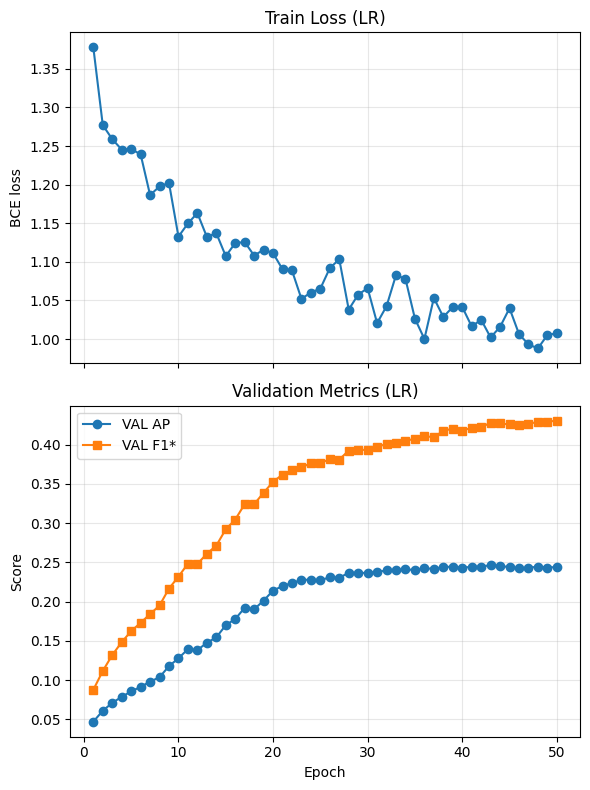

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [40]:
if not train_loss_hist:
    print("Training history empty — load skipped training or artifact lacks history. Run the training cell without a cached model to populate curves.")
else:
    epochs = np.arange(1, len(train_loss_hist) + 1)
    fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
    axes[0].plot(epochs, train_loss_hist, marker="o")
    axes[0].set_title("Train Loss (LR)")
    axes[0].set_ylabel("BCE loss")
    axes[0].grid(True, alpha=0.3)
    metric_epochs = np.arange(1, len(val_ap_hist) + 1)
    axes[1].plot(metric_epochs, val_ap_hist, marker="o", label="VAL AP")
    axes[1].plot(metric_epochs, val_f1_hist, marker="s", label="VAL F1*")
    axes[1].set_title("Validation Metrics (LR)")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Score")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("lr_metrics.png",dpi=300)
    plt.show()
    files.download("lr_metrics.png")

In [41]:
def _format_metric(val, unit=None, precision=3):
    if val is None:
        return "—"
    if isinstance(val, (int, np.integer)) and unit is None:
        return f"{int(val)}"
    if isinstance(val, (float, np.floating)):
        if np.isnan(val):
            return "—"
        if unit == "ms":
            return f"{val * 1e3:.3f} {unit}"
        if unit == "GB":
            return f"{val:.3f} {unit}"
        return f"{val:.3f}{'' if unit is None else ' ' + unit}"
    return str(val)

compute_metrics_display = {
    "Learnable parameters": _format_metric(compute_metrics.get("param_count")),
    "Avg. epoch wall time": _format_metric(compute_metrics.get("avg_epoch"), unit="s"),
    "Epoch time stdev": _format_metric(compute_metrics.get("std_epoch"), unit="s"),
    "Training throughput": _format_metric(compute_metrics.get("throughput_tiles_per_s"), unit="tiles/s"),
    "Peak GPU memory": _format_metric(compute_metrics.get("peak_gpu_gb"), unit="GB"),
    "Inference latency (1 tile)": _format_metric(compute_metrics.get("latency_s"), unit="ms"),
}

print("\n[LR] Computation metrics summary:")
for k, v in compute_metrics_display.items():
    print(f"  {k:28s} {v}")


[LR] Computation metrics summary:
  Learnable parameters         20
  Avg. epoch wall time         4.575 s
  Epoch time stdev             0.443 s
  Training throughput          262.273 tiles/s
  Peak GPU memory              0.026 GB
  Inference latency (1 tile)   0.158 ms


In [42]:
sample = train_ds[0]          # grab the first tile from the training split
img = sample["X_raw"]         # shape (channels, height, width)
print("Tensor shape:", img.shape)
print("Height x Width:", img.shape[1], "x", img.shape[2])

Tensor shape: torch.Size([19, 64, 64])
Height x Width: 64 x 64



[LR] Coefficients (sorted by |weight|):
  prev_fire        +2.2008
  erc              +0.3829
  gust_med         +0.3818
  wind_75          -0.3051
  temp             +0.1948
  barrier          -0.1831
  bi               +0.1622
  water            -0.1076
  fuel3            -0.0968
  fuel2            +0.0961
  rh               -0.0834
  slope            +0.0820
  ... (+7 more)
[LR] Bias: -0.5643


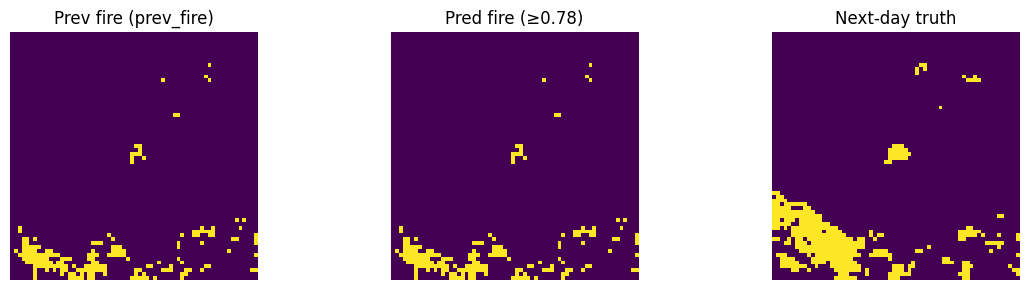

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:
# =========================================================
# 6) Inspect coefficients + quick viz (channel-aware)
# =========================================================
import numpy as np
import torch
import matplotlib.pyplot as plt

with torch.no_grad():
    # Weight per input channel
    W = lr_model.lin.weight[0, :, 0, 0].detach().cpu().numpy()   # shape (C,)
    B = float(lr_model.lin.bias.item())

# Use the dataset's channel names (matches model input order)
channel_names = list(train_ds.channels)  # e.g., ["prev_fire","u","v",...]
assert len(W) == len(channel_names), "Weight length must match channel count"

# Sort by absolute weight; show top-k (or all)
top_k = min(12, len(W))
coef_sorted = sorted(zip(channel_names, W), key=lambda x: -abs(x[1]))
print("\n[LR] Coefficients (sorted by |weight|):")
for name, w in coef_sorted[:top_k]:
    print(f"  {name:16s} {w:+.4f}")
if top_k < len(W):
    print(f"  ... (+{len(W)-top_k} more)")
print(f"[LR] Bias: {B:+.4f}")

# Quick qualitative visualization (prev_fire, pred mask, next truth)
@torch.no_grad()
def show_one_lr(ds, i=0):
    names = ds.channels
    prev_idx = names.index("prev_fire") if "prev_fire" in names else 0

    b = ds[i]
    X_raw0 = b["X_raw"].unsqueeze(0).to(device)       # (1,C,H,W)
    y = b["y"][0].numpy()                              # (H,W)

    X = build_lr_input(X_raw0, mean=meanC, std=stdC)   # uses channel-aware stats
    prob = torch.sigmoid(lr_model(X))[0, 0].cpu().numpy()
    pred_fire = (prob >= float(best_thr_val)).astype(np.float32)

    prev_img = b["X_raw"][prev_idx].numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    axs[0].imshow(prev_img, vmin=0, vmax=1); axs[0].set_title(f"Prev fire ({names[prev_idx]})")
    axs[1].imshow(pred_fire, vmin=0, vmax=1); axs[1].set_title(f"Pred fire (≥{best_thr_val:.2f})")
    axs[2].imshow(y, vmin=0, vmax=1);        axs[2].set_title("Next-day truth")
    for a in axs: a.axis('off')
    plt.tight_layout();
    plt.savefig("lr_burnviz.png",dpi=300)
    plt.show()
    files.download("lr_burnviz.png")

# Example
show_one_lr(test_ds, i=0)

In [44]:
# =========================================================
# 7) Save artifacts (channel-aware, non-/content path)
# =========================================================
import os
import torch

ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "lr")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "pixel_logreg.pt")

artifact = {
    "state_dict": {k: v.cpu() for k, v in lr_model.state_dict().items()},
    "model": {"type": "PixelLogReg", "in_ch": len(train_ds.channels)},
    "channels": list(train_ds.channels),
    "mean": meanC.cpu(),
    "std": stdC.cpu(),
    "pos_weight": float(pw),
    "best_thr": float(best_thr_val),
    "train_loss_hist": list(train_loss_hist),
    "val_ap_hist": list(val_ap_hist),
    "val_f1_hist": list(val_f1_hist),
    "val_thr_hist": list(val_thr_hist),
    "compute_metrics": dict(compute_metrics),
}

torch.save(artifact, ART_PATH)
print(f"Saved model → {ART_PATH}")

Saved model → /root/wildfire_artifacts/lr/pixel_logreg.pt


In [45]:
test_ap_lr, test_f1_lr

(np.float64(0.22584005911890911), np.float32(0.4124666))

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] VAL: AP=0.2466 F1*=0.4282 thr≈0.777
VAL @thr: {'tp': 16685, 'fp': 23937, 'tn': 1167558, 'fn': 20620, 'precision': 0.41073802373088214, 'recall': 0.44725908055208496, 'f1': 0.42822127903117524}
TEST @thr: {'tp': 17370, 'fp': 28025, 'tn': 1161945, 'fn': 21460, 'precision': 0.38264126005058213, 'recall': 0.4473345351531169, 'f1': 0.41246660233215005}


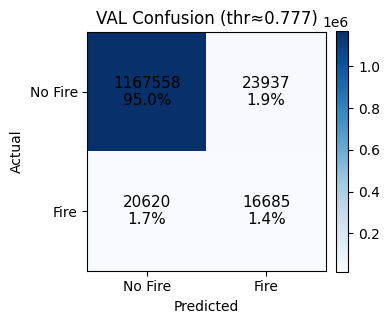

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

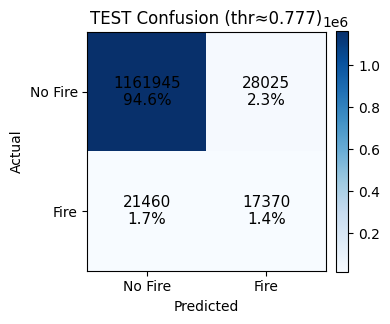

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_curve

# Reconfirm best threshold on VAL (uses your eval_lr)
val_ap, val_f1, best_thr_val = eval_lr(val_loader)
print(f"[LR] VAL: AP={val_ap:.4f} F1*={val_f1:.4f} thr≈{best_thr_val:.3f}")

@torch.no_grad()
def confusion_at_thr(loader, thr):
    lr_model.eval()
    tp = fp = tn = fn = 0
    for b in loader:
        X_raw0, y = b["X_raw"].to(device), b["y"].to(device)   # (B,1,H,W)
        X = build_lr_input(X_raw0)                              # normalize
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()  # probs
        t = y.flatten().cpu().numpy().astype(np.uint8)          # 0/1
        p = np.nan_to_num(p, nan=0.0)                           # safety
        yhat = (p >= thr).astype(np.uint8)
        tp += np.logical_and(yhat == 1, t == 1).sum()
        fp += np.logical_and(yhat == 1, t == 0).sum()
        tn += np.logical_and(yhat == 0, t == 0).sum()
        fn += np.logical_and(yhat == 0, t == 1).sum()
    tp, fp, tn, fn = map(int, (tp, fp, tn, fn))
    prec = tp / (tp + fp + 1e-8)
    rec  = tp / (tp + fn + 1e-8)
    f1   = 2 * prec * rec / (prec + rec + 1e-8)
    return dict(tp=tp, fp=fp, tn=tn, fn=fn,
                precision=float(prec), recall=float(rec), f1=float(f1))

def _conf_matrix_from_counts(stats):
    return np.array([[stats["tn"], stats["fp"]],
                     [stats["fn"], stats["tp"]]], dtype=np.int32)

def _plot_confusion(cm, title):
    total = cm.sum()
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["No Fire", "Fire"])
    ax.set_yticklabels(["No Fire", "Fire"])
    for (i, j), val in np.ndenumerate(cm):
        pct = (val / total * 100.0) if total else 0.0
        ax.text(j, i, f"{val}\n{pct:.1f}%", ha="center", va="center", color="black", fontsize=11)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout();
    plt.savefig("confusion.png",dpi=300)
    plt.show()
    files.download("confusion.png")

val_stats = confusion_at_thr(val_loader, best_thr_val)
test_stats = confusion_at_thr(test_loader, best_thr_val)

print("VAL @thr:", val_stats)
print("TEST @thr:", test_stats)

_plot_confusion(_conf_matrix_from_counts(val_stats), "VAL Confusion (thr≈{:.3f})".format(best_thr_val))
_plot_confusion(_conf_matrix_from_counts(test_stats), "TEST Confusion (thr≈{:.3f})".format(best_thr_val))



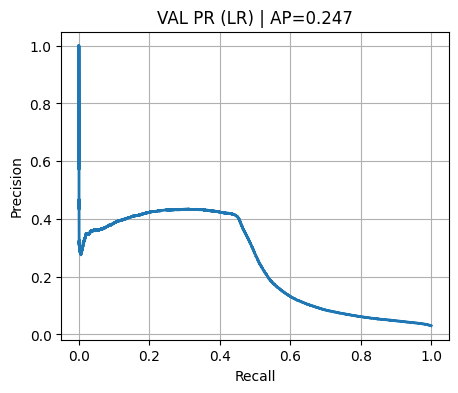

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

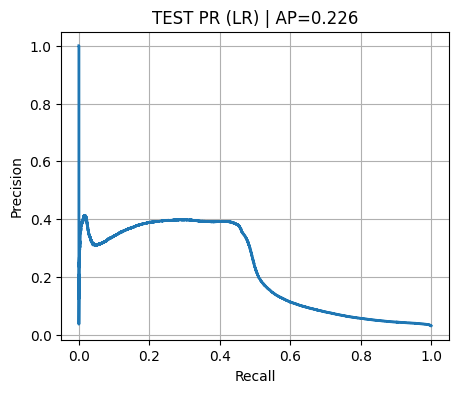

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
import matplotlib.pyplot as plt
from google.colab import files
@torch.no_grad()
def pr_curve(loader, title="PR Curve (LR)"):
    lr_model.eval()
    ps, ts = [], []
    for b in loader:
        X_raw0, y = b["X_raw"].to(device), b["y"].to(device)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        ps.append(p); ts.append(t)
    p = np.concatenate(ps); t = np.concatenate(ts)
    prec, rec, _ = precision_recall_curve(t, p)
    ap = average_precision_score(t, p)
    plt.figure(figsize=(5,4))
    plt.plot(rec, prec, lw=2)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title} | AP={ap:.3f}")
    plt.grid(True);
    plot_name = title.replace(" ", "_") + ".png"
    plt.savefig(plot_name,dpi=300)
    plt.show()
    files.download(plot_name)

pr_curve(val_loader, "VAL PR (LR)")
pr_curve(test_loader, "TEST PR (LR)")


In [48]:
# Single-feature ablation: evaluate LR using one channel at a time
single_feats = list(train_ds.channels)  # uses the configured channel order

@torch.no_grad()
def eval_single_feature(idx, loader=val_loader):
    C = len(single_feats)
    assert 0 <= idx < C, f"idx out of range (got {idx}, C={C})"

    # Save current weights/bias
    W_orig = lr_model.lin.weight.detach().clone()  # (1,C,1,1)
    b_orig = lr_model.lin.bias.detach().clone()

    # Zero all weights except the selected channel
    W_only = torch.zeros_like(W_orig)
    W_only[0, idx, 0, 0] = W_orig[0, idx, 0, 0]

    lr_model.lin.weight.data.copy_(W_only)
    lr_model.lin.bias.data.copy_(b_orig)  # keep bias unchanged

    # Evaluate on the given loader
    ap, f1, _ = eval_lr(loader)

    # Restore original weights/bias
    lr_model.lin.weight.data.copy_(W_orig)
    lr_model.lin.bias.data.copy_(b_orig)

    return ap, f1

abl = []
for i, nm in enumerate(single_feats):
    ap_i, f1_i = eval_single_feature(i, loader=val_loader)
    abl.append((nm, ap_i, f1_i))

abl = sorted(abl, key=lambda x: -x[2])  # sort by F1
print("\n[LR] Single-feature VAL ablations (sorted by F1):")
for nm, ap_i, f1_i in abl:
    print(f"  {nm:16s}  AP={ap_i:.3f}  F1*={f1_i:.3f}")

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]


[LR] Single-feature VAL ablations (sorted by F1):
  prev_fire         AP=0.210  F1*=0.439
  erc               AP=0.046  F1*=0.094
  bi                AP=0.043  F1*=0.088
  rh                AP=0.040  F1*=0.073
  temp              AP=0.037  F1*=0.068
  v                 AP=0.033  F1*=0.065
  slope             AP=0.035  F1*=0.065
  gust_med          AP=0.034  F1*=0.065
  chili             AP=0.032  F1*=0.063
  barrier           AP=0.032  F1*=0.062
  fuel3             AP=0.030  F1*=0.062
  fuel2             AP=0.032  F1*=0.061
  fuel1             AP=0.029  F1*=0.061
  water             AP=0.031  F1*=0.060
  u                 AP=0.030  F1*=0.060
  impervious        AP=0.030  F1*=0.060
  wind_75           AP=0.027  F1*=0.060
  aspect            AP=0.030  F1*=0.060
  pr                AP=0.030  F1*=0.059


In [49]:
minus_topog_channels = ['prev_fire',
 'u',
 'v',
 'temp',
 'rh',
 'ndvi',
 'barrier',
 'erc',
 'pdsi',
 'pr',
 'bi',
 'chili',
 'impervious',
 'water',
 'wind_75',
 'gust_med']

In [50]:
# --- Use shared mNDWS DataPipeline outputs for NPZ tiles and loaders ---
try:
    mndws_dp
except NameError:
    import os
    os.environ.setdefault("MNDWS_PIPELINE_SILENT", "1")
    import mNDWS_DataPipeline as mndws_dp
    WildfireDataset = mndws_dp.WildfireDataset
    WildfirePaths = mndws_dp.WildfirePaths
    CH_ORDER_BASE = mndws_dp.CH_ORDER_BASE
    CH_ORDER_EXTRA = mndws_dp.CH_ORDER_EXTRA

NPZ_ROOT = mndws_dp.NPZ_ROOT
print(f'Reusing NPZ tiles from pipeline at: {NPZ_ROOT}')

CHANNELS_FOR_MODEL = minus_topog_channels #list(mndws_dp.USE_CHANNELS)  # adjust here if you want fewer features
paths = mndws_dp.WildfirePaths(NPZ_ROOT)

train_ds = mndws_dp.WildfireDataset(paths, split='train', max_samples=1200, channels=CHANNELS_FOR_MODEL)
val_ds   = mndws_dp.WildfireDataset(paths, split='eval',  max_samples=300,  channels=CHANNELS_FOR_MODEL)
test_ds  = mndws_dp.WildfireDataset(paths, split='test',  max_samples=300,  channels=CHANNELS_FOR_MODEL)

train_loader = mndws_dp.make_loader(train_ds, batch_size=16, upweight_positive=True)
val_loader   = mndws_dp.make_loader(val_ds,   batch_size=16)
test_loader  = mndws_dp.make_loader(test_ds,  batch_size=16)

meanC, stdC = mndws_dp.compute_channel_stats(train_ds, n_max_samples=2000, batch_size=32)
meanC, stdC = meanC.to(device), stdC.to(device)

print(f'Channels configured ({len(CHANNELS_FOR_MODEL)}): {CHANNELS_FOR_MODEL}')

Reusing NPZ tiles from pipeline at: /scratch/root/wildfire_npz_tiles_mndws_v1


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Channels configured (16): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'impervious', 'water', 'wind_75', 'gust_med']


In [51]:
# =========================================================
# 4) Pixel Logistic Regression (1x1 conv) — mNDWS channel-aware, change number of epochs here
# =========================================================
import torch.nn as nn

class PixelLogReg(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.lin = nn.Conv2d(in_ch, 1, kernel_size=1, bias=True)
    def forward(self, x):
        return self.lin(x)  # logits (B,1,H,W)

def build_lr_input(X_raw0, mean=meanC, std=stdC):
    # Normalize using stats for the configured channels
    return (X_raw0 - mean.view(1, -1, 1, 1)) / std.view(1, -1, 1, 1)

@torch.no_grad()
def pos_weight_from_loader(loader, max_batches=100):
    total_pos = 0
    total = 0
    for i, b in enumerate(loader):
        y = b["y"]
        total_pos += y.sum().item()
        total     += y.numel()
        if i+1 >= max_batches: break
    pos = max(total_pos, 1.0)
    neg = max(total - total_pos, 1.0)
    return torch.tensor(neg / pos, dtype=torch.float32, device=device)

# Match model input to selected channels
n_ch = len(train_ds.channels)
assert meanC.numel() == n_ch and stdC.numel() == n_ch, "Stats must match channel count"

lr_model = PixelLogReg(in_ch=n_ch).to(device)
pw = pos_weight_from_loader(train_loader)
criterion = nn.BCEWithLogitsLoss(pos_weight=pw)
optimizer = torch.optim.AdamW(lr_model.parameters(), lr=1e-3, weight_decay=1e-4)

# change number of epochs here
EPOCHS_LR = 50
print("in_ch =", n_ch, "pos_weight =", float(pw))

in_ch = 16 pos_weight = 32.25057601928711


In [52]:
# =========================================================
# 5) Train / Eval loops, change number of epochs above
# =========================================================
import matplotlib.pyplot as plt
import time

def train_lr_epoch():
    lr_model.train()
    losses = []
    tiles_seen = 0
    for b in tqdm(train_loader, desc="train LR", leave=False):
        X_raw0, y = b["X_raw"].to(device, non_blocking=True), b["y"].to(device, non_blocking=True)
        X = build_lr_input(X_raw0)
        logits = lr_model(X)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        tiles_seen += X_raw0.size(0)
    return float(np.mean(losses)), tiles_seen

@torch.no_grad()
def eval_lr(loader):
    lr_model.eval()
    all_p, all_t = [], []
    for b in tqdm(loader, desc="eval LR", leave=False):
        X_raw0, y = b["X_raw"].to(device, non_blocking=True), b["y"].to(device, non_blocking=True)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p)
        all_t.append(t)
    p = np.concatenate(all_p)
    t = np.concatenate(all_t)
    if t.sum() == 0:
        return 0.0, 0.0, 0.5
    ap = average_precision_score(t, p)
    prec, rec, thr = precision_recall_curve(t, p)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    best_idx = f1.argmax()
    best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
    return float(ap), float(f1.max()), float(best_thr)

# Shared artifact path so we can skip retraining when cached weights exist
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "lr")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "pixel_logreg.pt")

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist = [], [], [], []
best_thr_val = 0.5
cached_artifact = False
artifact = {}

peak_gpu_gb = None
epoch_times = []
epoch_tiles = []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in lr_model.parameters() if p.requires_grad)),
}

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)

if os.path.exists(ART_PATH):
    print(f"Loading cached PixelLogReg artifact from {ART_PATH}")
    artifact = torch.load(ART_PATH, map_location=device)
    saved_channels = artifact.get("channels")
    current_channels = list(train_ds.channels)
    if saved_channels == current_channels:
        lr_model.load_state_dict(artifact["state_dict"])
        best_thr_val = float(artifact.get("best_thr", 0.5))
        train_loss_hist = list(artifact.get("train_loss_hist", []))
        val_ap_hist = list(artifact.get("val_ap_hist", []))
        val_f1_hist = list(artifact.get("val_f1_hist", []))
        val_thr_hist = list(artifact.get("val_thr_hist", []))
        compute_metrics.update(artifact.get("compute_metrics", {}))
        cached_artifact = True
    else:
        print("Cached artifact channel order differs from requested dataset; retraining.")
else:
    print("No cached PixelLogReg artifact found; training from scratch.")

if not cached_artifact:
    best_val_ap_lr = -1.0
    best_state = None

    for e in range(EPOCHS_LR):
        if use_cuda:
            torch.cuda.synchronize(device)
        elif use_mps:
            torch.mps.synchronize()
        epoch_start = time.perf_counter()
        tr_loss, tiles_seen = train_lr_epoch()
        if use_cuda:
            torch.cuda.synchronize(device)
        elif use_mps:
            torch.mps.synchronize()
        epoch_duration = time.perf_counter() - epoch_start
        epoch_times.append(epoch_duration)
        epoch_tiles.append(tiles_seen)
        ap, f1, thr = eval_lr(val_loader)
        train_loss_hist.append(tr_loss)
        val_ap_hist.append(ap)
        val_f1_hist.append(f1)
        val_thr_hist.append(thr)
        print(f"[LR] Epoch {e:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | thr≈{thr:.3f}")
        if ap > best_val_ap_lr:
            best_val_ap_lr = ap
            best_state = {k: v.cpu().clone() for k, v in lr_model.state_dict().items()}

    if best_state is not None:
        lr_model.load_state_dict(best_state)

    _, _, best_thr_val = eval_lr(val_loader)
    if val_thr_hist:
        val_thr_hist[-1] = best_thr_val
    else:
        val_thr_hist.append(best_thr_val)

    if epoch_times:
        avg_epoch = float(np.mean(epoch_times))
        std_epoch = float(np.std(epoch_times))
        total_time = float(np.sum(epoch_times))
        total_tiles = int(np.sum(epoch_tiles)) if epoch_tiles else 0
        throughput = float(total_tiles / total_time) if total_time > 0 else None
    else:
        avg_epoch = std_epoch = throughput = None
    if use_cuda:
        torch.cuda.synchronize(device)
        peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
    elif use_mps:
        torch.mps.synchronize()
    latency_s = None
else:
    if not val_thr_hist:
        val_ap, val_f1, best_thr_val = eval_lr(val_loader)
        val_ap_hist = [val_ap]
        val_f1_hist = [val_f1]
        val_thr_hist = [best_thr_val]
        print("Cached artifact missing history; recomputed validation metrics.")
    else:
        best_thr_val = float(artifact.get("best_thr", val_thr_hist[-1]))
    avg_epoch = compute_metrics.get("avg_epoch", None)
    std_epoch = compute_metrics.get("std_epoch", None)
    throughput = compute_metrics.get("throughput_tiles_per_s", None)
    peak_gpu_gb = compute_metrics.get("peak_gpu_gb", None)
    latency_s = compute_metrics.get("latency_s", None)

@torch.no_grad()
def test_at_thr(thr):
    lr_model.eval()
    all_p, all_t = [], []
    for b in tqdm(test_loader, desc="test LR", leave=False):
        X_raw0, y = b["X_raw"].to(device, non_blocking=True), b["y"].to(device, non_blocking=True)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p)
        all_t.append(t)
    p = np.concatenate(all_p)
    t = np.concatenate(all_t)
    ap = average_precision_score(t, p)
    yhat = (p >= thr).astype(np.float32)
    tp = (yhat * t).sum()
    fp = (yhat * (1 - t)).sum()
    fn = ((1 - yhat) * t).sum()
    prec = tp / (tp + fp + 1e-8)
    rec = tp / (tp + fn + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)
    print(f"[LR] TEST @thr={thr:.3f} | AP={ap:.4f} | P={prec:.3f} R={rec:.3f} F1={f1:.3f}")
    return ap, f1

test_ap_lr, test_f1_lr = test_at_thr(best_thr_val)

@torch.no_grad()
def measure_latency(ds, repeats=50):
    if len(ds) == 0:
        return None
    lr_model.eval()
    sample = ds[0]["X_raw"].unsqueeze(0).to(device)
    X = build_lr_input(sample)
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    start = time.perf_counter()
    for _ in range(repeats):
        torch.sigmoid(lr_model(X))
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    return (time.perf_counter() - start) / repeats

if latency_s is None:
    latency_s = measure_latency(test_ds, repeats=100)
if use_cuda and peak_gpu_gb is None:
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))

compute_metrics.update({
    "avg_epoch": avg_epoch,
    "std_epoch": std_epoch,
    "throughput_tiles_per_s": throughput,
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s,
})

Loading cached PixelLogReg artifact from /root/wildfire_artifacts/lr/pixel_logreg.pt
Cached artifact channel order differs from requested dataset; retraining.


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 00 | loss 1.4378 | VAL AP 0.0266 | VAL F1* 0.0595 | thr≈0.289


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 01 | loss 1.3637 | VAL AP 0.0359 | VAL F1* 0.0691 | thr≈0.553


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 02 | loss 1.2983 | VAL AP 0.0498 | VAL F1* 0.1012 | thr≈0.599


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 03 | loss 1.2906 | VAL AP 0.0617 | VAL F1* 0.1267 | thr≈0.624


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 04 | loss 1.1857 | VAL AP 0.0720 | VAL F1* 0.1435 | thr≈0.630


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 05 | loss 1.1708 | VAL AP 0.0815 | VAL F1* 0.1580 | thr≈0.631


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 06 | loss 1.1757 | VAL AP 0.0934 | VAL F1* 0.1760 | thr≈0.644


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 07 | loss 1.1370 | VAL AP 0.1020 | VAL F1* 0.1900 | thr≈0.643


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 08 | loss 1.1355 | VAL AP 0.1150 | VAL F1* 0.2101 | thr≈0.661


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 09 | loss 1.1176 | VAL AP 0.1277 | VAL F1* 0.2324 | thr≈0.658


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 10 | loss 1.0982 | VAL AP 0.1367 | VAL F1* 0.2525 | thr≈0.663


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 11 | loss 1.1068 | VAL AP 0.1435 | VAL F1* 0.2614 | thr≈0.679


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 12 | loss 1.0716 | VAL AP 0.1556 | VAL F1* 0.2770 | thr≈0.684


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 13 | loss 1.1094 | VAL AP 0.1665 | VAL F1* 0.2936 | thr≈0.673


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 14 | loss 1.0416 | VAL AP 0.1762 | VAL F1* 0.3032 | thr≈0.686


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 15 | loss 1.0618 | VAL AP 0.1855 | VAL F1* 0.3135 | thr≈0.688


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 16 | loss 1.0741 | VAL AP 0.1905 | VAL F1* 0.3208 | thr≈0.691


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 17 | loss 1.0860 | VAL AP 0.1937 | VAL F1* 0.3252 | thr≈0.697


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 18 | loss 1.0342 | VAL AP 0.1993 | VAL F1* 0.3342 | thr≈0.695


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 19 | loss 1.0710 | VAL AP 0.2041 | VAL F1* 0.3393 | thr≈0.697


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 20 | loss 1.0559 | VAL AP 0.2027 | VAL F1* 0.3414 | thr≈0.708


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 21 | loss 1.0278 | VAL AP 0.2100 | VAL F1* 0.3516 | thr≈0.711


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 22 | loss 1.0335 | VAL AP 0.2161 | VAL F1* 0.3575 | thr≈0.710


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 23 | loss 1.0513 | VAL AP 0.2194 | VAL F1* 0.3609 | thr≈0.714


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 24 | loss 0.9964 | VAL AP 0.2194 | VAL F1* 0.3634 | thr≈0.716


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 25 | loss 1.0236 | VAL AP 0.2242 | VAL F1* 0.3699 | thr≈0.724


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 26 | loss 1.0139 | VAL AP 0.2335 | VAL F1* 0.3805 | thr≈0.735


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 27 | loss 1.0132 | VAL AP 0.2394 | VAL F1* 0.3893 | thr≈0.711


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 28 | loss 1.0136 | VAL AP 0.2407 | VAL F1* 0.3919 | thr≈0.721


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 29 | loss 0.9945 | VAL AP 0.2415 | VAL F1* 0.3935 | thr≈0.725


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 30 | loss 0.9938 | VAL AP 0.2423 | VAL F1* 0.3964 | thr≈0.734


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 31 | loss 1.0186 | VAL AP 0.2416 | VAL F1* 0.3956 | thr≈0.741


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 32 | loss 1.0038 | VAL AP 0.2426 | VAL F1* 0.3990 | thr≈0.748


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 33 | loss 0.9749 | VAL AP 0.2445 | VAL F1* 0.4030 | thr≈0.747


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 34 | loss 0.9628 | VAL AP 0.2445 | VAL F1* 0.4029 | thr≈0.749


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 35 | loss 0.9468 | VAL AP 0.2481 | VAL F1* 0.4079 | thr≈0.755


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 36 | loss 0.9828 | VAL AP 0.2487 | VAL F1* 0.4097 | thr≈0.758


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 37 | loss 1.0064 | VAL AP 0.2483 | VAL F1* 0.4109 | thr≈0.772


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 38 | loss 0.9529 | VAL AP 0.2468 | VAL F1* 0.4120 | thr≈0.772


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 39 | loss 0.9836 | VAL AP 0.2480 | VAL F1* 0.4140 | thr≈0.773


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 40 | loss 1.0124 | VAL AP 0.2470 | VAL F1* 0.4153 | thr≈0.786


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 41 | loss 0.9932 | VAL AP 0.2471 | VAL F1* 0.4168 | thr≈0.786


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 42 | loss 0.9813 | VAL AP 0.2484 | VAL F1* 0.4181 | thr≈0.791


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 43 | loss 0.9634 | VAL AP 0.2491 | VAL F1* 0.4199 | thr≈0.781


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 44 | loss 0.9769 | VAL AP 0.2497 | VAL F1* 0.4206 | thr≈0.783


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 45 | loss 1.0185 | VAL AP 0.2502 | VAL F1* 0.4207 | thr≈0.794


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 46 | loss 0.9795 | VAL AP 0.2505 | VAL F1* 0.4208 | thr≈0.796


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 47 | loss 0.9464 | VAL AP 0.2510 | VAL F1* 0.4214 | thr≈0.798


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 48 | loss 0.9469 | VAL AP 0.2499 | VAL F1* 0.4222 | thr≈0.801


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 49 | loss 0.9819 | VAL AP 0.2499 | VAL F1* 0.4223 | thr≈0.810


eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


test LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] TEST @thr=0.798 | AP=0.2340 | P=0.379 R=0.433 F1=0.404


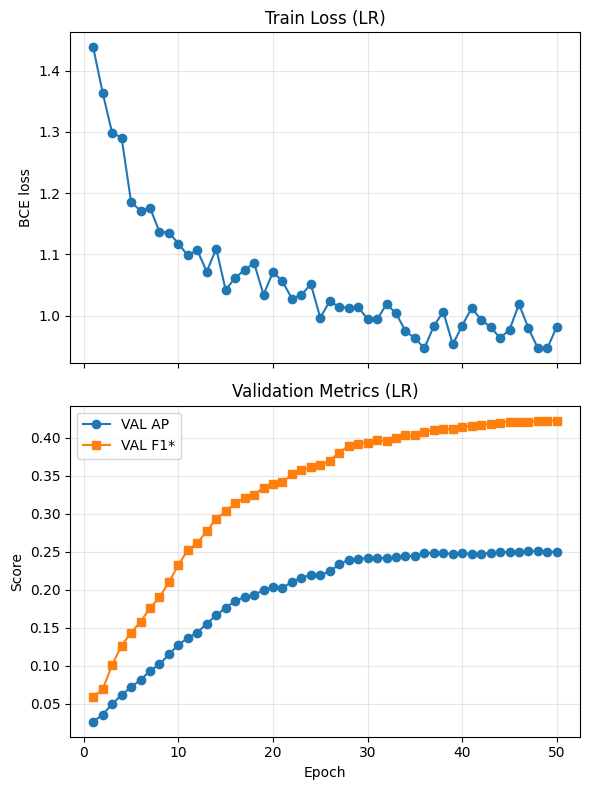

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
if not train_loss_hist:
    print("Training history empty — load skipped training or artifact lacks history. Run the training cell without a cached model to populate curves.")
else:
    epochs = np.arange(1, len(train_loss_hist) + 1)
    fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
    axes[0].plot(epochs, train_loss_hist, marker="o")
    axes[0].set_title("Train Loss (LR)")
    axes[0].set_ylabel("BCE loss")
    axes[0].grid(True, alpha=0.3)
    metric_epochs = np.arange(1, len(val_ap_hist) + 1)
    axes[1].plot(metric_epochs, val_ap_hist, marker="o", label="VAL AP")
    axes[1].plot(metric_epochs, val_f1_hist, marker="s", label="VAL F1*")
    axes[1].set_title("Validation Metrics (LR)")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Score")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("lr_metrics.png",dpi=300)
    plt.show()
    files.download("lr_metrics.png")

In [54]:
def _format_metric(val, unit=None, precision=3):
    if val is None:
        return "—"
    if isinstance(val, (int, np.integer)) and unit is None:
        return f"{int(val)}"
    if isinstance(val, (float, np.floating)):
        if np.isnan(val):
            return "—"
        if unit == "ms":
            return f"{val * 1e3:.3f} {unit}"
        if unit == "GB":
            return f"{val:.3f} {unit}"
        return f"{val:.3f}{'' if unit is None else ' ' + unit}"
    return str(val)

compute_metrics_display = {
    "Learnable parameters": _format_metric(compute_metrics.get("param_count")),
    "Avg. epoch wall time": _format_metric(compute_metrics.get("avg_epoch"), unit="s"),
    "Epoch time stdev": _format_metric(compute_metrics.get("std_epoch"), unit="s"),
    "Training throughput": _format_metric(compute_metrics.get("throughput_tiles_per_s"), unit="tiles/s"),
    "Peak GPU memory": _format_metric(compute_metrics.get("peak_gpu_gb"), unit="GB"),
    "Inference latency (1 tile)": _format_metric(compute_metrics.get("latency_s"), unit="ms"),
}

print("\n[LR] Computation metrics summary:")
for k, v in compute_metrics_display.items():
    print(f"  {k:28s} {v}")


[LR] Computation metrics summary:
  Learnable parameters         17
  Avg. epoch wall time         4.083 s
  Epoch time stdev             0.501 s
  Training throughput          293.930 tiles/s
  Peak GPU memory              0.023 GB
  Inference latency (1 tile)   0.094 ms


In [55]:
sample = train_ds[0]          # grab the first tile from the training split
img = sample["X_raw"]         # shape (channels, height, width)
print("Tensor shape:", img.shape)
print("Height x Width:", img.shape[1], "x", img.shape[2])

Tensor shape: torch.Size([16, 64, 64])
Height x Width: 64 x 64



[LR] Coefficients (sorted by |weight|):
  prev_fire        +2.3878
  gust_med         +0.3827
  wind_75          -0.2782
  pdsi             -0.2665
  erc              +0.2605
  barrier          -0.2466
  bi               +0.2137
  temp             +0.1907
  rh               -0.1227
  water            -0.1174
  ndvi             +0.0610
  v                -0.0532
  ... (+4 more)
[LR] Bias: -0.6479


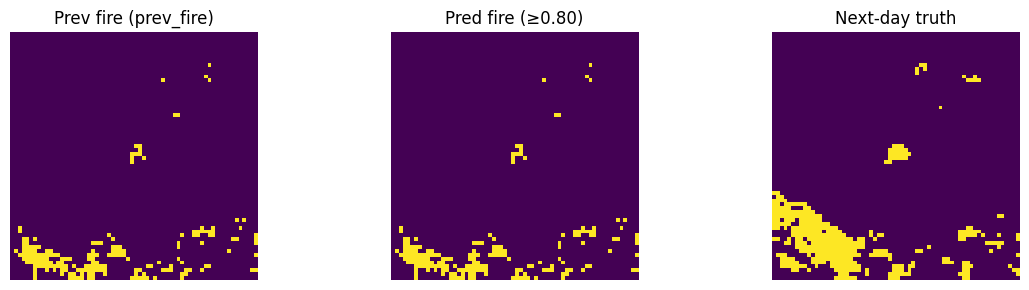

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
# =========================================================
# 6) Inspect coefficients + quick viz (channel-aware)
# =========================================================
import numpy as np
import torch
import matplotlib.pyplot as plt

with torch.no_grad():
    # Weight per input channel
    W = lr_model.lin.weight[0, :, 0, 0].detach().cpu().numpy()   # shape (C,)
    B = float(lr_model.lin.bias.item())

# Use the dataset's channel names (matches model input order)
channel_names = list(train_ds.channels)  # e.g., ["prev_fire","u","v",...]
assert len(W) == len(channel_names), "Weight length must match channel count"

# Sort by absolute weight; show top-k (or all)
top_k = min(12, len(W))
coef_sorted = sorted(zip(channel_names, W), key=lambda x: -abs(x[1]))
print("\n[LR] Coefficients (sorted by |weight|):")
for name, w in coef_sorted[:top_k]:
    print(f"  {name:16s} {w:+.4f}")
if top_k < len(W):
    print(f"  ... (+{len(W)-top_k} more)")
print(f"[LR] Bias: {B:+.4f}")

# Quick qualitative visualization (prev_fire, pred mask, next truth)
@torch.no_grad()
def show_one_lr(ds, i=0):
    names = ds.channels
    prev_idx = names.index("prev_fire") if "prev_fire" in names else 0

    b = ds[i]
    X_raw0 = b["X_raw"].unsqueeze(0).to(device)       # (1,C,H,W)
    y = b["y"][0].numpy()                              # (H,W)

    X = build_lr_input(X_raw0, mean=meanC, std=stdC)   # uses channel-aware stats
    prob = torch.sigmoid(lr_model(X))[0, 0].cpu().numpy()
    pred_fire = (prob >= float(best_thr_val)).astype(np.float32)

    prev_img = b["X_raw"][prev_idx].numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    axs[0].imshow(prev_img, vmin=0, vmax=1); axs[0].set_title(f"Prev fire ({names[prev_idx]})")
    axs[1].imshow(pred_fire, vmin=0, vmax=1); axs[1].set_title(f"Pred fire (≥{best_thr_val:.2f})")
    axs[2].imshow(y, vmin=0, vmax=1);        axs[2].set_title("Next-day truth")
    for a in axs: a.axis('off')
    plt.tight_layout();
    plt.savefig("lr_burnviz.png",dpi=300)
    plt.show()
    files.download("lr_burnviz.png")

# Example
show_one_lr(test_ds, i=0)

In [57]:
# =========================================================
# 7) Save artifacts (channel-aware, non-/content path)
# =========================================================
import os
import torch

ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "lr")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "pixel_logreg.pt")

artifact = {
    "state_dict": {k: v.cpu() for k, v in lr_model.state_dict().items()},
    "model": {"type": "PixelLogReg", "in_ch": len(train_ds.channels)},
    "channels": list(train_ds.channels),
    "mean": meanC.cpu(),
    "std": stdC.cpu(),
    "pos_weight": float(pw),
    "best_thr": float(best_thr_val),
    "train_loss_hist": list(train_loss_hist),
    "val_ap_hist": list(val_ap_hist),
    "val_f1_hist": list(val_f1_hist),
    "val_thr_hist": list(val_thr_hist),
    "compute_metrics": dict(compute_metrics),
}

torch.save(artifact, ART_PATH)
print(f"Saved model → {ART_PATH}")

Saved model → /root/wildfire_artifacts/lr/pixel_logreg.pt


In [58]:
test_ap_lr, test_f1_lr

(np.float64(0.2340209095926652), np.float32(0.40446195))

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] VAL: AP=0.2510 F1*=0.4214 thr≈0.798
VAL @thr: {'tp': 16055, 'fp': 22834, 'tn': 1168661, 'fn': 21250, 'precision': 0.41284167759510076, 'recall': 0.4303712639055273, 'f1': 0.42142425413006573}
TEST @thr: {'tp': 16824, 'fp': 27538, 'tn': 1162432, 'fn': 22006, 'precision': 0.3792434966862677, 'recall': 0.43327324233828657, 'f1': 0.40446196251888666}


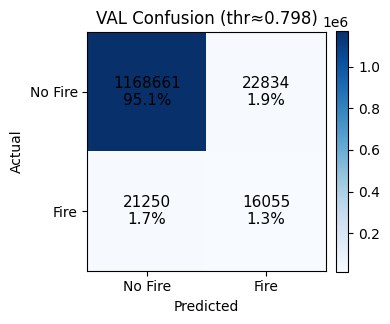

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

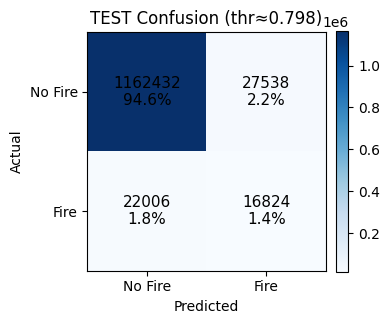

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_curve

# Reconfirm best threshold on VAL (uses your eval_lr)
val_ap, val_f1, best_thr_val = eval_lr(val_loader)
print(f"[LR] VAL: AP={val_ap:.4f} F1*={val_f1:.4f} thr≈{best_thr_val:.3f}")

@torch.no_grad()
def confusion_at_thr(loader, thr):
    lr_model.eval()
    tp = fp = tn = fn = 0
    for b in loader:
        X_raw0, y = b["X_raw"].to(device), b["y"].to(device)   # (B,1,H,W)
        X = build_lr_input(X_raw0)                              # normalize
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()  # probs
        t = y.flatten().cpu().numpy().astype(np.uint8)          # 0/1
        p = np.nan_to_num(p, nan=0.0)                           # safety
        yhat = (p >= thr).astype(np.uint8)
        tp += np.logical_and(yhat == 1, t == 1).sum()
        fp += np.logical_and(yhat == 1, t == 0).sum()
        tn += np.logical_and(yhat == 0, t == 0).sum()
        fn += np.logical_and(yhat == 0, t == 1).sum()
    tp, fp, tn, fn = map(int, (tp, fp, tn, fn))
    prec = tp / (tp + fp + 1e-8)
    rec  = tp / (tp + fn + 1e-8)
    f1   = 2 * prec * rec / (prec + rec + 1e-8)
    return dict(tp=tp, fp=fp, tn=tn, fn=fn,
                precision=float(prec), recall=float(rec), f1=float(f1))

def _conf_matrix_from_counts(stats):
    return np.array([[stats["tn"], stats["fp"]],
                     [stats["fn"], stats["tp"]]], dtype=np.int32)

def _plot_confusion(cm, title):
    total = cm.sum()
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["No Fire", "Fire"])
    ax.set_yticklabels(["No Fire", "Fire"])
    for (i, j), val in np.ndenumerate(cm):
        pct = (val / total * 100.0) if total else 0.0
        ax.text(j, i, f"{val}\n{pct:.1f}%", ha="center", va="center", color="black", fontsize=11)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout();
    plt.savefig("confusion.png",dpi=300)
    plt.show()
    files.download("confusion.png")

val_stats = confusion_at_thr(val_loader, best_thr_val)
test_stats = confusion_at_thr(test_loader, best_thr_val)

print("VAL @thr:", val_stats)
print("TEST @thr:", test_stats)

_plot_confusion(_conf_matrix_from_counts(val_stats), "VAL Confusion (thr≈{:.3f})".format(best_thr_val))
_plot_confusion(_conf_matrix_from_counts(test_stats), "TEST Confusion (thr≈{:.3f})".format(best_thr_val))



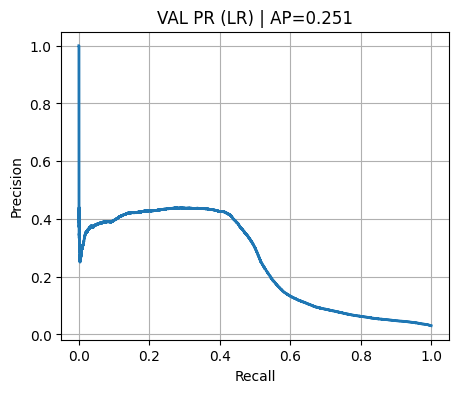

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

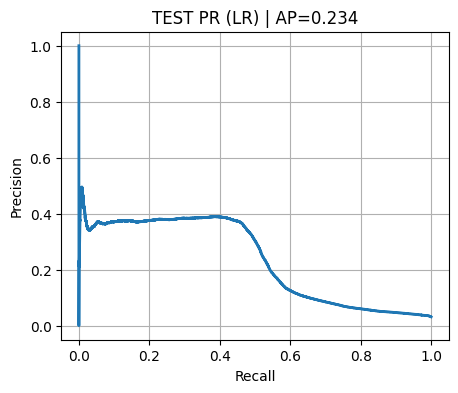

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [60]:
import matplotlib.pyplot as plt
from google.colab import files
@torch.no_grad()
def pr_curve(loader, title="PR Curve (LR)"):
    lr_model.eval()
    ps, ts = [], []
    for b in loader:
        X_raw0, y = b["X_raw"].to(device), b["y"].to(device)
        X = build_lr_input(X_raw0)
        p = torch.sigmoid(lr_model(X)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        ps.append(p); ts.append(t)
    p = np.concatenate(ps); t = np.concatenate(ts)
    prec, rec, _ = precision_recall_curve(t, p)
    ap = average_precision_score(t, p)
    plt.figure(figsize=(5,4))
    plt.plot(rec, prec, lw=2)
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{title} | AP={ap:.3f}")
    plt.grid(True);
    plot_name = title.replace(" ", "_") + ".png"
    plt.savefig(plot_name,dpi=300)
    plt.show()
    files.download(plot_name)

pr_curve(val_loader, "VAL PR (LR)")
pr_curve(test_loader, "TEST PR (LR)")


In [61]:
# Single-feature ablation: evaluate LR using one channel at a time
single_feats = list(train_ds.channels)  # uses the configured channel order

@torch.no_grad()
def eval_single_feature(idx, loader=val_loader):
    C = len(single_feats)
    assert 0 <= idx < C, f"idx out of range (got {idx}, C={C})"

    # Save current weights/bias
    W_orig = lr_model.lin.weight.detach().clone()  # (1,C,1,1)
    b_orig = lr_model.lin.bias.detach().clone()

    # Zero all weights except the selected channel
    W_only = torch.zeros_like(W_orig)
    W_only[0, idx, 0, 0] = W_orig[0, idx, 0, 0]

    lr_model.lin.weight.data.copy_(W_only)
    lr_model.lin.bias.data.copy_(b_orig)  # keep bias unchanged

    # Evaluate on the given loader
    ap, f1, _ = eval_lr(loader)

    # Restore original weights/bias
    lr_model.lin.weight.data.copy_(W_orig)
    lr_model.lin.bias.data.copy_(b_orig)

    return ap, f1

abl = []
for i, nm in enumerate(single_feats):
    ap_i, f1_i = eval_single_feature(i, loader=val_loader)
    abl.append((nm, ap_i, f1_i))

abl = sorted(abl, key=lambda x: -x[2])  # sort by F1
print("\n[LR] Single-feature VAL ablations (sorted by F1):")
for nm, ap_i, f1_i in abl:
    print(f"  {nm:16s}  AP={ap_i:.3f}  F1*={f1_i:.3f}")

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]


[LR] Single-feature VAL ablations (sorted by F1):
  prev_fire         AP=0.210  F1*=0.439
  erc               AP=0.046  F1*=0.094
  pdsi              AP=0.043  F1*=0.089
  bi                AP=0.043  F1*=0.088
  rh                AP=0.040  F1*=0.073
  temp              AP=0.037  F1*=0.068
  v                 AP=0.033  F1*=0.065
  gust_med          AP=0.034  F1*=0.065
  pr                AP=0.032  F1*=0.063
  barrier           AP=0.032  F1*=0.062
  ndvi              AP=0.028  F1*=0.061
  water             AP=0.031  F1*=0.060
  u                 AP=0.030  F1*=0.060
  impervious        AP=0.030  F1*=0.060
  wind_75           AP=0.027  F1*=0.060
  chili             AP=0.029  F1*=0.059
